In [1]:
%matplotlib notebook

In [2]:
# Import python modules
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, MultiPoint, Polygon
from sklearn.gaussian_process.kernels import Matern
from shapely.wkt import loads
from scipy.spatial.ckdtree import cKDTree
import matplotlib.pyplot as plt
import netCDF4
import h5py
import gc, sys, os
sys.path.append("../scripts")
import spatial_functions
import aem_utils
import netcdf_utils
import modelling_utils
import plotting_functions as plots
import warnings
import numpy.ma as ma
warnings.filterwarnings('ignore')

Import borehole and AEM data


In [51]:
infile = r"/home/ubuntu/workshop_data/boreholes/NT_Cretaceous_bores.csv"
df = pd.read_csv(infile)


gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.POINT_X, df.POINT_Y)).dropna().set_crs("EPSG:4283")

# We want to reproject to gda94 zone52

gdf = gdf.to_crs("EPSG:28352")

gdf['easting'] = [gdf['geometry'][i].x for i in range(len(gdf))]
gdf['northing'] = [gdf['geometry'][i].y for i in range(len(gdf))]

In [17]:
# The actual inversoin data are stored on disk as netcdf files. NetCDF is an efficient format for storing 
# self-describing containerised data. 
# The implementation of netcdf for AEM line data was done by Alex Ip using his geophys_utils package.
# https://github.com/GeoscienceAustralia/geophys_utils/tree/master/geophys_utils

# Define path to the netcdf file
infile = "../../workshop_data/lci/DalyR_WB_MGA52.nc"

# Create an instance
lci = aem_utils.AEM_inversion(name = 'Laterally Contrained Inversion (LCI)',
                              inversion_type = 'deterministic',
                              netcdf_dataset = netCDF4.Dataset(infile))

# As these inversions have already been gridded we will add these raster datasets to the instance using the
# load_lci_layer_grid() function. This function belongs to the AEM_inversion class.

# Directory in which the grids are located
inRaster = "../../workshop_data/lci/lci_grids"

# Run function
lci.load_lci_layer_grids(inRaster, conversion_to_SI = True, nlayers = 30)



In [5]:
# Now we import a pre-existing Cretaceous boundary

def parse_asc_raster(infile):
    raster = {}
    with open(infile, 'r') as f:
        for i in range(6):
            l = f.readline().split()
            raster[l[0]] = np.float(l[1])
        arr = np.loadtxt(f)
        arr[np.isclose(arr, raster['NODATA_value'])] = np.nan
        raster['data'] = arr
    return raster

infile = "../../workshop_data/interpretation/Base - Cretaceous contacts.asc"

cret_boundary = parse_asc_raster(infile)

Let examine the results of this process. The inversion data is stored as an attribute of the inversion
class lci. It can be accessed by running the 'lci.data' command.


In [6]:
print(lci.data)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    geospatial_east_min: 684789.625
    geospatial_east_max: 910249.5
    geospatial_east_units: m
    geospatial_north_min: 8309173.0
    geospatial_north_max: 8495335.0
    geospatial_north_units: m
    title: Dataset read from ASEG-GDF file DalyR_WB_MGA52_temp.dat
    Conventions: CF-1.6,ACDD-1.3
    featureType: trajectory
    geospatial_vertical_min: 
    geospatial_vertical_max: 302.2
    geospatial_vertical_units: m
    geospatial_vertical_resolution: point
    geospatial_vertical_positive: up
    history: Converted from ASEG-GDF file C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\2017_DalyRiver_SkyTEM\03_LCI\01_Data\DalyR_WB_MGA52_temp.dat using definitions file C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\2017_DalyRiver_SkyTEM\03_LCI\01_Data\DalyR_WB_MGA52.dfn
    date_created: 2019-10-07T16:54:15.324169
    geospatial_east_resolution: point
    geospatial_north_resolution: point
    geospatial

In [7]:
# The attributes and properties of the instance of the AEM inversion class can be viewed with the dir() command.

print(dir(lci))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'coords', 'data', 'grid_sections', 'grid_variables', 'inversion_type', 'layer_grids', 'load_gridded_sections', 'load_lci_layer_grids', 'load_sections_from_file', 'name', 'xmax', 'xmin', 'ymax', 'ymin']


Create an instance of the garjmcmctdem inversion and probe the results using the same syntax as above.

In [8]:
# Path to netcdf file
infile = "../../workshop_data/rj/DR_rjmcmc_pmaps.nc"

# Create instance
rj = aem_utils.AEM_inversion(name = 'GARJMCMCTDEM',
                              inversion_type = 'stochastic',
                              netcdf_dataset = netCDF4.Dataset(infile))

Here we examine some of the attributes of the rj class

In [9]:
# here we print a few of the attributes
print(rj.data)


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    nlayers_min: 1
    nlayers_max: 25
    nsamples: 500000
    nchains: 8
    nburnin: 50000
    thinrate: 10
    min_log10_conductivity: -3.0
    max_log10_conductivity: 0.0
    min_depth: 0.0
    max_depth: 500.0
    value_parameterization: LOG10
    position_parameterization: LINEAR
    keywords: geophysics, airborne, AEM, conductivity, garjmcmcmtdem
    date_created: 2020-08-13 00:45:01.395023
    crs: GDA94 / MGA zone 52
    crs_geographic: GDA2020
    geospatial_east_min: 685573.31
    geospatial_east_max: 876829.38
    geospatial_east_units: m
    geospatial_north_min: 8314578.5
    geospatial_north_max: 8489437.0
    geospatial_north_units: m
    geospatial_vertical_min: 28.97
    geospatial_vertical_max: 294.57
    geospatial_vertical_units: m
    geospatial_lon_min: 130.7182738913254
    geospatial_lon_max: -13.654206832592617
    geospatial_lont_units: degrees North
    geospatial_lat_min:

In [10]:
# Now we have the lines we can grid the lci conductivity data onto vertical grids (known as sections)
# this is the easiest way to visualise the AEM conuctivity in 2-dimensions

# Assign the lci variables to grid
grid_vars = ['conductivity', 'data_residual']

# Define the resolution of the sections
xres, yres = 20., 5.

# We will use the lines from the rj

lines = np.unique(lci.data['line'][:].astype('int'))

print(lines)

# Define the output directory if saving the grids as hdf plots

hdf5_dir = "../../workshop_data/lci/hdf5"

# if the directory doesn't exist, then create it
if not os.path.exists(hdf5_dir):
    os.mkdir(hdf5_dir)  

# Gridding takes a few minutes so I pre-gridded them for you. The lci.grid_sections()
# function below will do the gridding for you. Instead we will use the load_sectoin_from_file()
# function, which loads hdf5 files produced using the grid_sections() function


lci.grid_sections(variables = grid_vars, lines = lines, xres = xres, yres = yres,
                  return_interpolated = True, save_hdf5 = True, hdf5_dir = hdf5_dir)

#lci.load_sections_from_file(hdf5_dir, grid_vars)

[100001 100101 100201 100301 100401 100501 100601 100701 100801 100901
 101001 101101 101201 101301 101401 101501 101502 101601 101701 101801
 101901 102001 102101 102201 102301 102401 102501 102601 102701 102801
 102901 103001 103101 103201 103301 103401 103501 103502 103601 103701
 103801 103901 104001 104101 104102 104201 104301 104302 104401 104501
 104601 104701 104801 104901 105001 105101 105201 105301 105401 105501
 105601 105602 105603 105701 105801 105901 105902 106001 106101 106201
 106301 106302 106401 106501 106601 106701 106801 106901 107001 107101
 107201 107301 107401 107501 107601 107701 107801 107901 108001 108101
 108201 108301 108401 108501 108601 108701 108801 108901 109001 109101
 109201 109202 109203 109204 109301 109302 109303 109401 109402 109501
 109502 109503 109504 109601 109701 109702 109703 109801 109802 109803
 109901 110001 110002 110003 110101 110102 110103 110201 110202 110203
 110301 110401 110501 110601 110701 110801 110901 111001 912001 912002
 91200

# 2. Visualise the data


Now let's quickly visualise the data. You can easily create your own plots if you are comfortable with the matplotlib python 
package. However, you may prefer to use some of the standard plots.

# 2.1 Map plot

Our first standard plot is an plot of gridded conductivity with the points inverted with GARJMCMCTDEM
plotted as points.

In [11]:
gdf['easting']

0      7.480302e+05
1      7.480302e+05
2      7.495890e+05
3      7.505301e+05
4      7.523301e+05
           ...     
668    1.129613e+06
669    1.134461e+06
670    1.147039e+06
671    1.162814e+06
672    1.167119e+06
Name: easting, Length: 673, dtype: float64

<IPython.core.display.Javascript object>


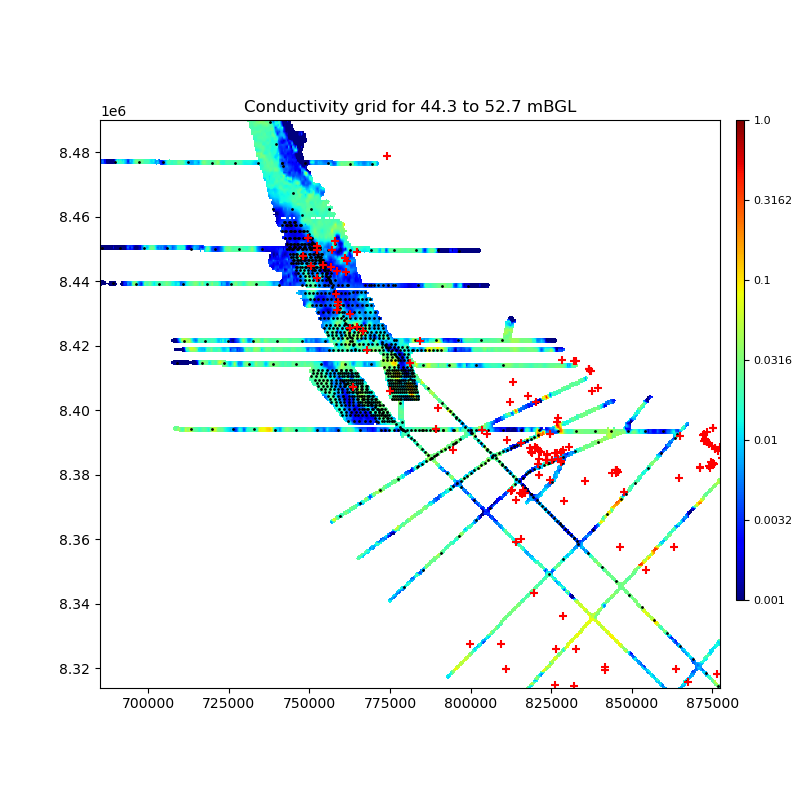

In [26]:
       
# In this notebook, standard plot key word arguments are passed to the plotting function as a python dictionary

# Here we explain each variable. Feel free to change and regenerate the plot
plot_args = {'Layer_number': 8, # Which AEM layer grid to plot from layer 1 (shallowest) to 30 (deepest)
             "figsize": (8,8), # The figure size in inches
             "vmin": 0.001, "vmax": 1., # The maximum and minimum conductivities in (S/m) for the grid colourstretch
             "point_size": 1, "point_colour": 'black', # Size and colour of the scatter plot points
             'colour_stretch': 'jet', # See matplotlib colourstretches
             'buffer': 500.} # The plot boundary will be buffered around the outer most scatter points.

plt.close('all')
# Do some plotting

fig, ax, cax = plots.AEM_baseplot(rj, lci, plot_args = plot_args)

# plot the bores
ax.scatter(gdf['easting'].values, gdf['northing'].values, marker = '+', c = 'r')

plt.show()

# 2.2 Section plot

Our next standard plot is a vertical AEM section. The rather irregular length of sections means these are
commonly customised. As such we have left it to the user to define the size of the panels.

<IPython.core.display.Javascript object>


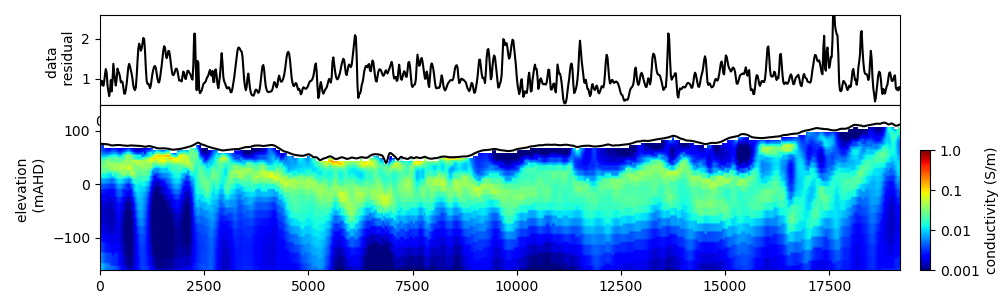

In [13]:
# Create a figures

fig = plt.figure(figsize = (10,3))

# Add two axes for the data misfit and the conductivity
# 
ax1 = fig.add_axes([0.1, 0.65, 0.8, 0.3])
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.55], sharex = ax1)

# Add a color
cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.4])

panel_kwargs = [{'title': '',
                      'color': 'black',
                      'ylabel': 'data \n residual',
                      'legend': False,
                      },
                     {'max_depth': 200.,
                      'shade_doi': False,
                      'colourbar': True,
                      'colourbar_label': 'Conductivity (S/m)',
                      'log_plot': True,
                      'vmin': 0.001,
                      'vmax': 1.,
                      'cmap': 'jet',
                      'ylabel': 'elevation \n (mAHD)'}]

# define your line
line = 105701

res = plots.plot_single_line(ax1, lci.section_data[line],
                                   'data_residual', panel_kwargs[0])

cond_section = plots.plot_grid(ax2, lci.section_data[line], 'conductivity',
                           panel_kwargs[1])

cb = fig.colorbar(cond_section, cax=cbar_ax, orientation='vertical')
    
cbar_ax.set_yticklabels([round(10 ** x, 4) for x in cb.get_ticks()])

cb.set_label('conductivity (S/m)', fontsize=10)

plt.show()

# 3 Setup your model

Now we want to create a model boundary object for our interpreted surface. As with AEM inversions our interpreted surface will be an instance of a python class. However, this class is called modelled boundary and has different data and funcionality.

In [13]:
# Create an modelled boundary instance

import importlib
importlib.reload(modelling_utils)

surface = modelling_utils.modelled_boundary(name = 'Cretaceous-CLA interface - elevation')

# If we have an extent we can load that as an attribute
infile = "../../workshop_data/interpretation/Cretaceous_extent.shp"

surface.load_extent_from_file(infile, index = 11)


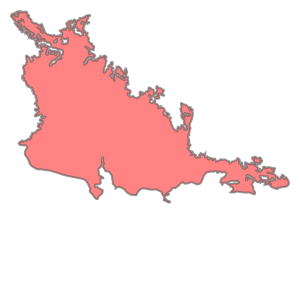

In [14]:
surface.extent

# 4 Interpreting



# 4.1 Sampling

Our sampling strategy is to find points that are close to our Cretaceous bores


In [166]:
bore_coords = gdf[['easting', 'northing']].values

dist,ind = spatial_functions.nearest_neighbours(bore_coords, rj.coords,
                                           points_required = 1,max_distance = 1000.)
points = ind[np.isfinite(dist)]

distances = dist[np.isfinite(dist)]

bore_ind = gdf[np.isfinite(dist)].index



In [194]:
# Next we define 
pmap_kwargs = {# Panel 1 is the 2d histogram of conductivity and depth.
               # Counts are converted to probabilities
               'panel_1': {'min_depth': 0,
                           'max_depth': 200.,
                           'cmap': 'rainbow'},
               # Panel 2 is the change point histogram panel. This shows
               # where we are most likely to have layer boundaries.
              'panel_2': {'auto_xlim': True,
                          'pmin': 0.001,
                          'pmax': 1.},
               # panel 3 is the interpolated surface grid described above.
              'panel_3': {'vmin': -300,
                          'vmax': 0.},
               # panel 4 shows the misfit for our MCMC chains. This plot shows
               # if our model has converged
              'panel_4': {'misfit_min': 0.01,
                          'misfit_max': 1e4},
               # panel 5 shows the lci misft for a section.
              'panel_5': {'title': '',
                      'color': 'black',
                      'ylabel': 'data \n residual',
                      'legend': False,
                         'buffer': 5000.},
               # panel 6 shows the lci conducivity Section
              'panel_6': {'title': 'LCI conductivity',
                      'max_depth': 200.,
                      'vmin': 0.001,
                      'vmax': 1,
                      'cmap': 'jet',
                      'ylabel': 'elevation \n (mAHD)',
                       'buffer': 5000.,
                       'shade_doi': False},
               # panel 7 shows the gridded AEM conductivity.
              'panel_7': {'Layer_number': 4,
                          "vmin": 0.001, "vmax": 1.,
                          'cmap': 'jet',
                          'buffer': 20000.}}

The pmap click function below is what allows us to interact with the plots. The click2estimate function takes a click from the plot and returns and interpretation. The function searches all points within the snap window (which is defined as 16 here) and finds the local maximum porbability of an interface. This is in effect snapping to the most likely interface within the serach region. If you are highly confident in your picks you can reduce the snap window.


It also returns the thickness of the probability intervals that is >0.5 times the local maximum probability. In many areas, especially at depth this method returns errors that are unrealistically high. Thus the user can define a standard deviation ceilling (stdev_ceiling) or a maximum possible standard deviation.

In [195]:
# The results are saved to the same file we imported earlier
outfile = "../../workshop_data/interpretation/rj_interp_Cretaceous.csv"

# Interpretations ar saved to this list
interpretations = []

# Define the interative parameters
snap_window = 16
stdev_ceiling = 20.

# pmaps function
def pmap_click(event):
    if event.xdata != None and event.ydata != None:
        #We will use fiducial as a key

        depth, stdev = modelling_utils.click2estimate(D, event.ydata,
                                                       snap_window = snap_window,
                                                       stdev_ceiling = stdev_ceiling)
        # append to the surface object interpreted points
        interp = {'fiducial': D['fiducial'],
                  'easting': D['easting'],
                  'northing': D['northing'],
                  'layer_depth': np.round(depth,0),
                  'layer_elevation': np.round(D['elevation'] - event.ydata,2),
                  'interpretation_uncertainty': np.round(stdev,0)}
        
        #interpretations.append(interp)                        
        df = pd.DataFrame(interp, index = [0]).set_index('fiducial')

        try:
            surface.interpreted_points = surface.interpreted_points.append(df, verify_integrity = True)
        # Value error is if the point has already been interpreted
        except ValueError:
            surface.interpreted_points.loc[df.index, df.columns] = df.values[0]

        # Save the interpretation
        surface.interpreted_points.to_csv(outfile)


To interterpret on our pmap we simply click either panel one or two where we think our interface or feature of interest is found.

In [196]:
i = 0


In [199]:
def plot_K_depth(ind):
    depth = gdf.iloc[ind]['gLevelSRTM'] - gdf.iloc[ind]['bCretElev']
    print(depth)
    ax_array[0].plot(ax_array[0].get_xlim(), [depth,depth], c = 'red')
    ax_array[1].plot(ax_array[1].get_xlim(), [depth,depth], c = 'red')
    return ax_array
    

Since interpretation appears difficult.... instead we export the pmaps with the Cretaceous interface plotted over the top.

<IPython.core.display.Javascript object>


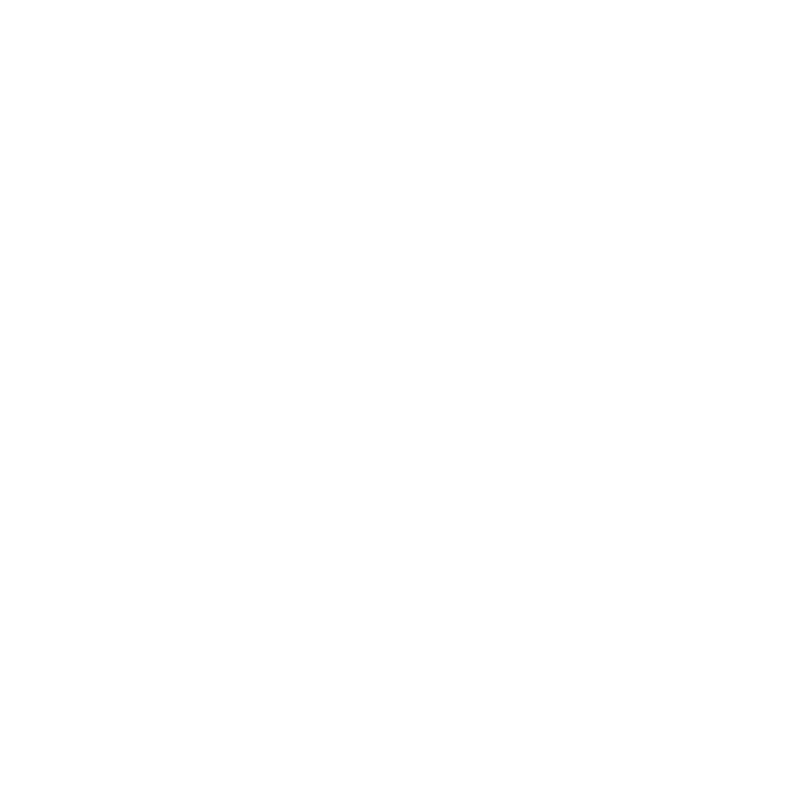

21.0


<IPython.core.display.Javascript object>


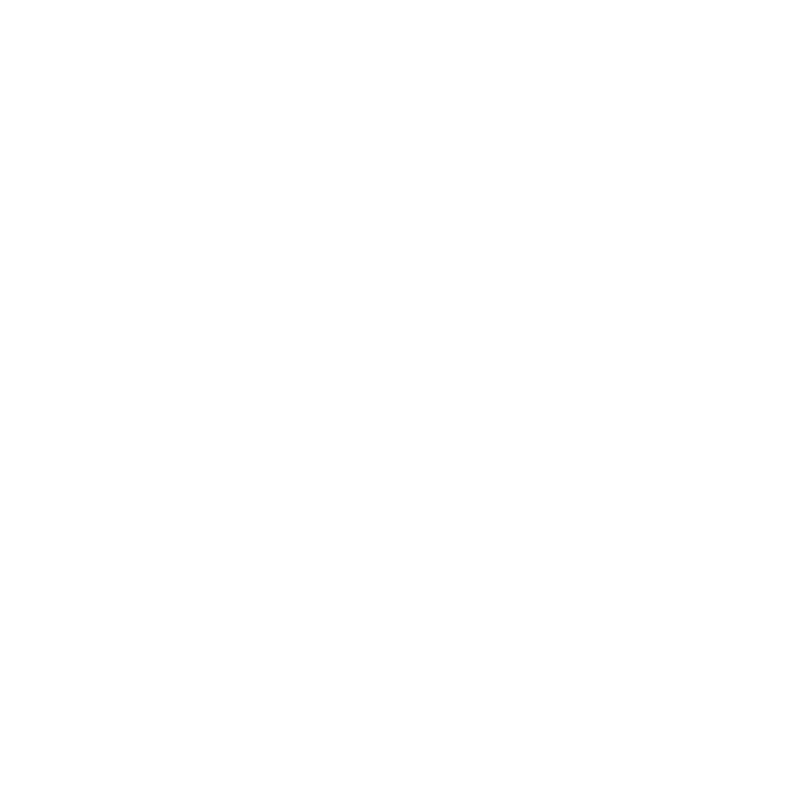

24.0


<IPython.core.display.Javascript object>


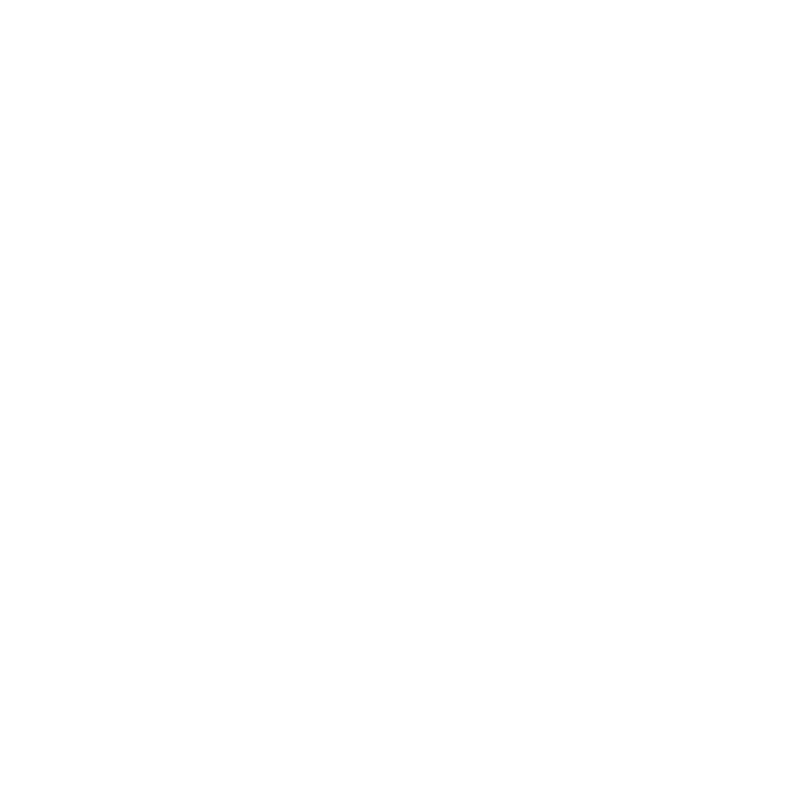

13.999999999999993


<IPython.core.display.Javascript object>


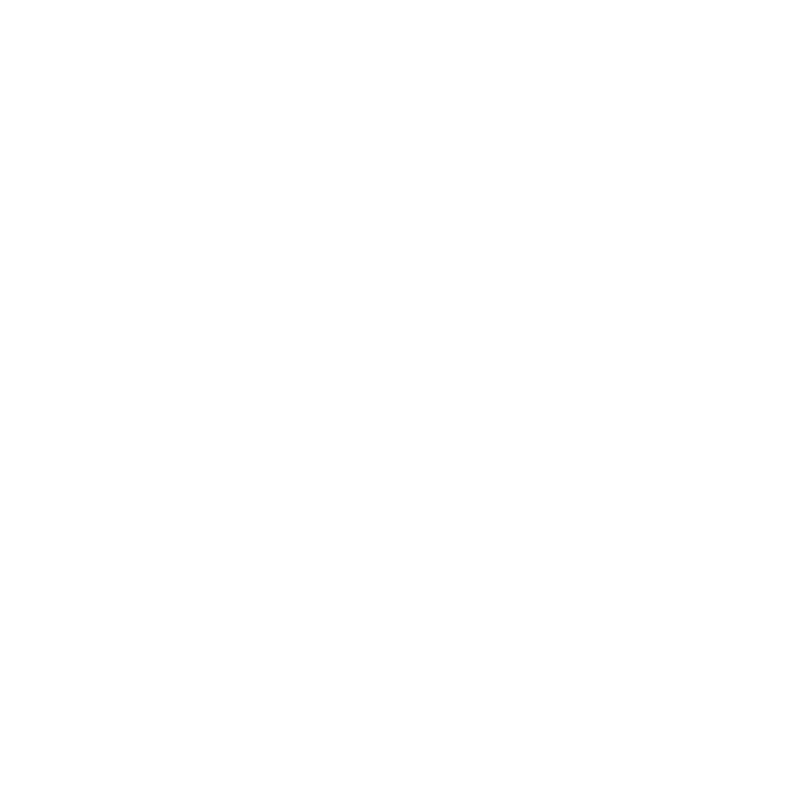

13.0


<IPython.core.display.Javascript object>


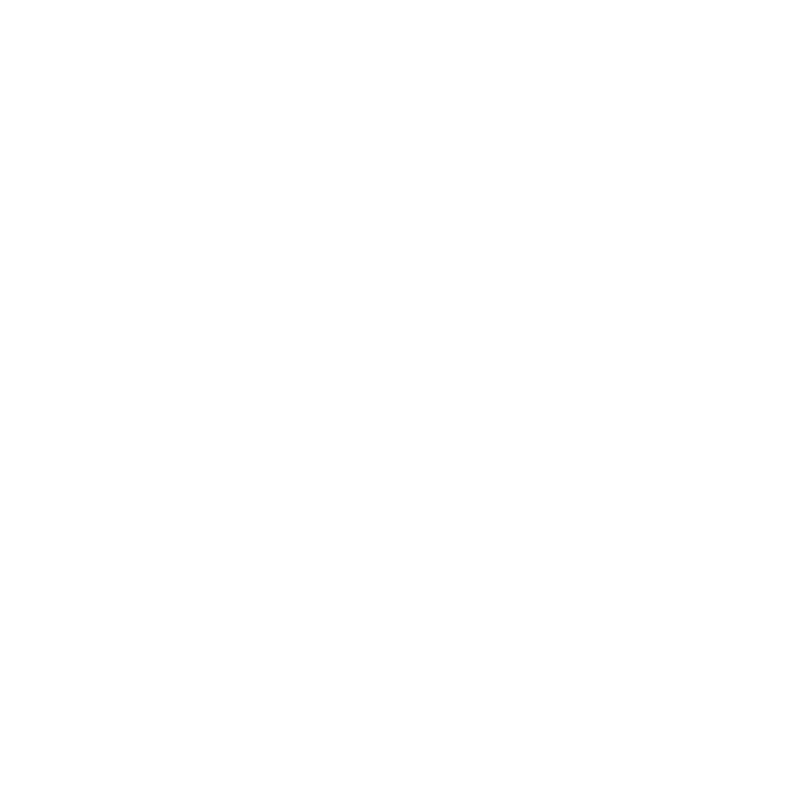

21.0


<IPython.core.display.Javascript object>


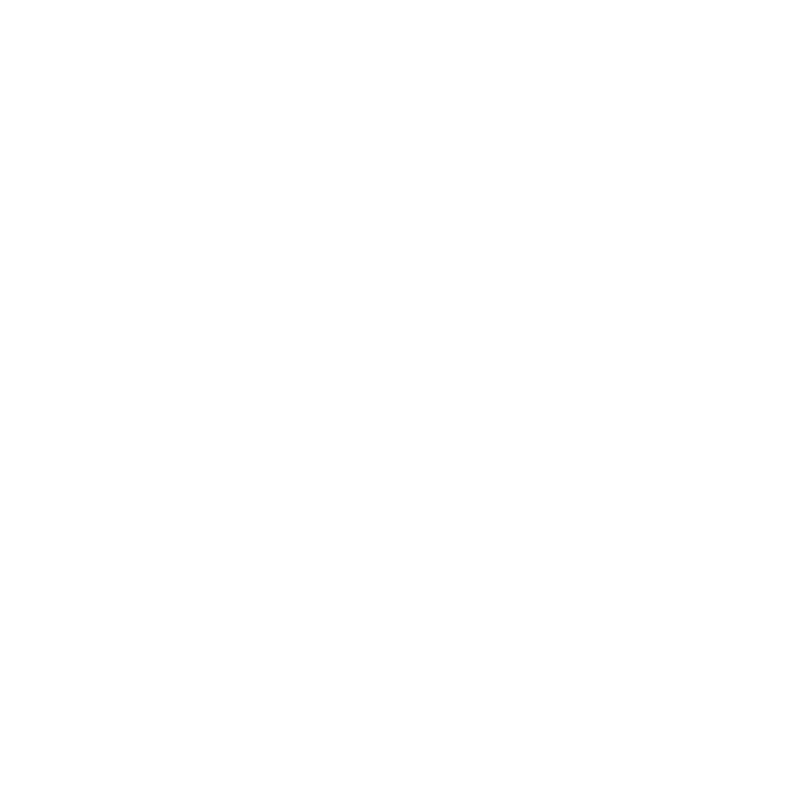

15.0


<IPython.core.display.Javascript object>


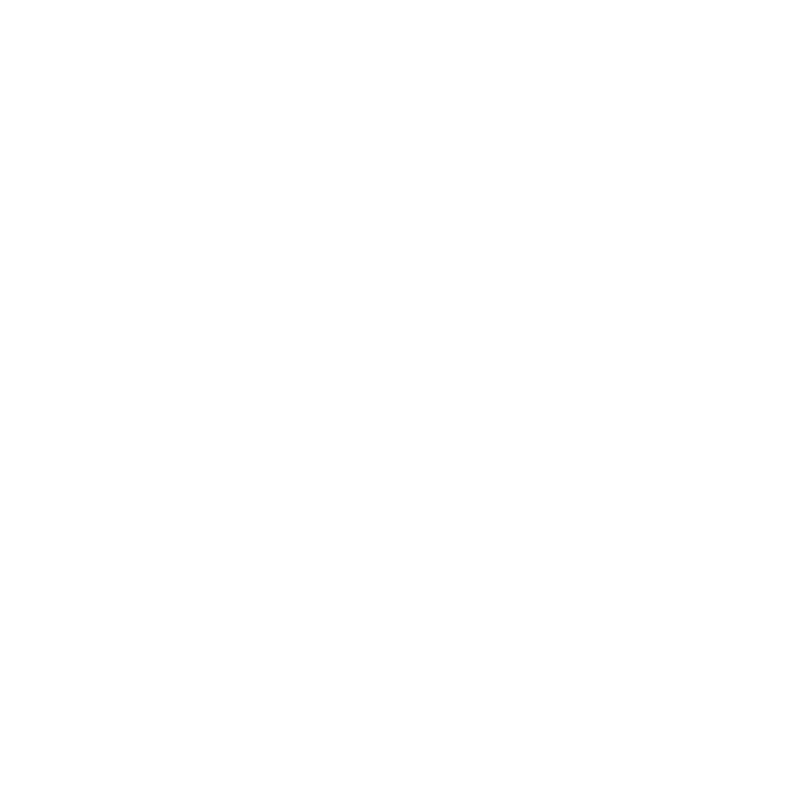

29.0


<IPython.core.display.Javascript object>


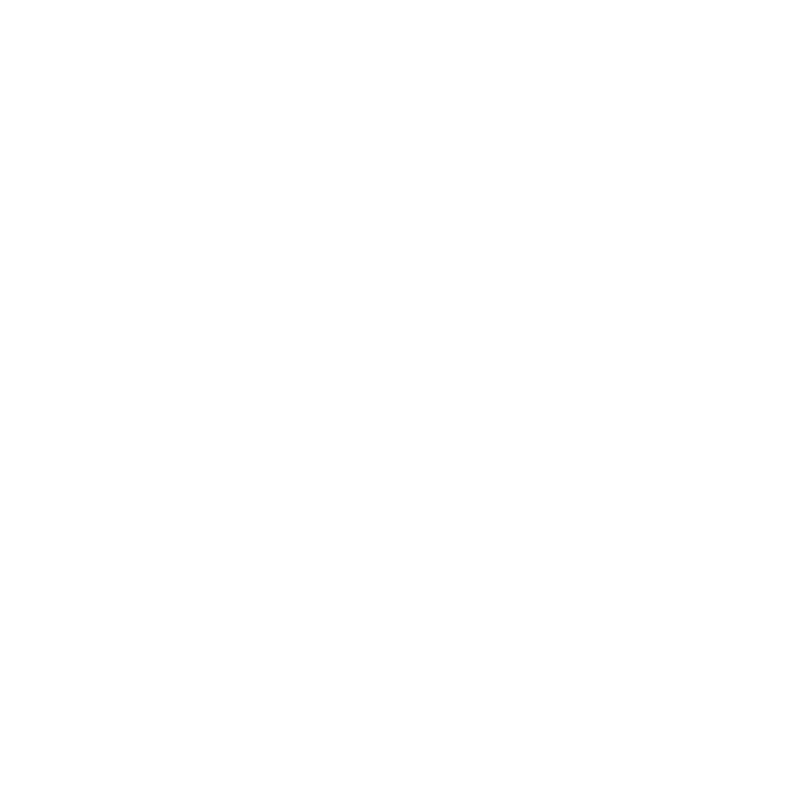

72.0


<IPython.core.display.Javascript object>


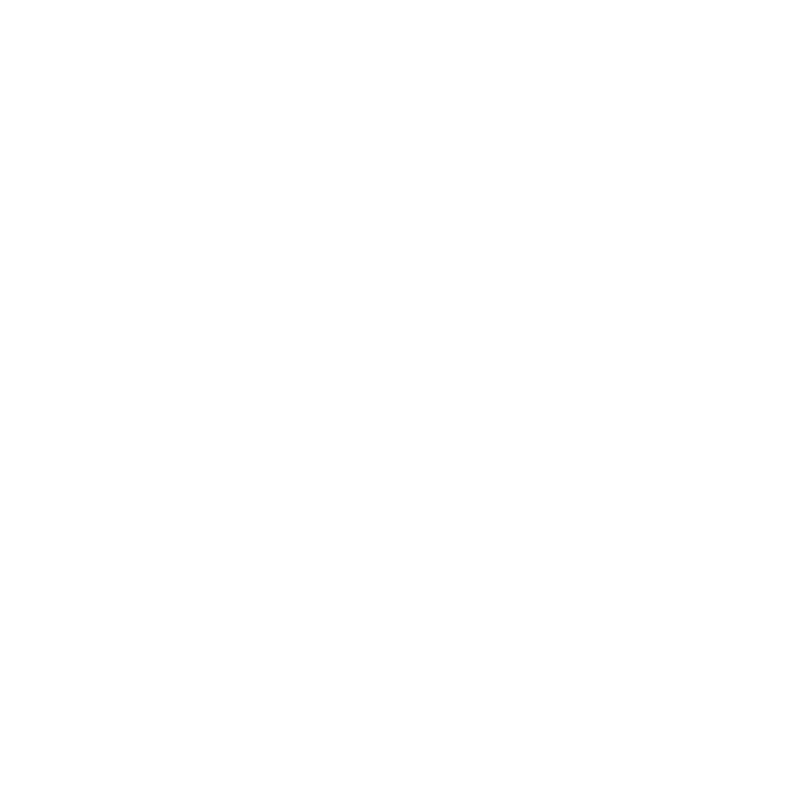

15.0


<IPython.core.display.Javascript object>


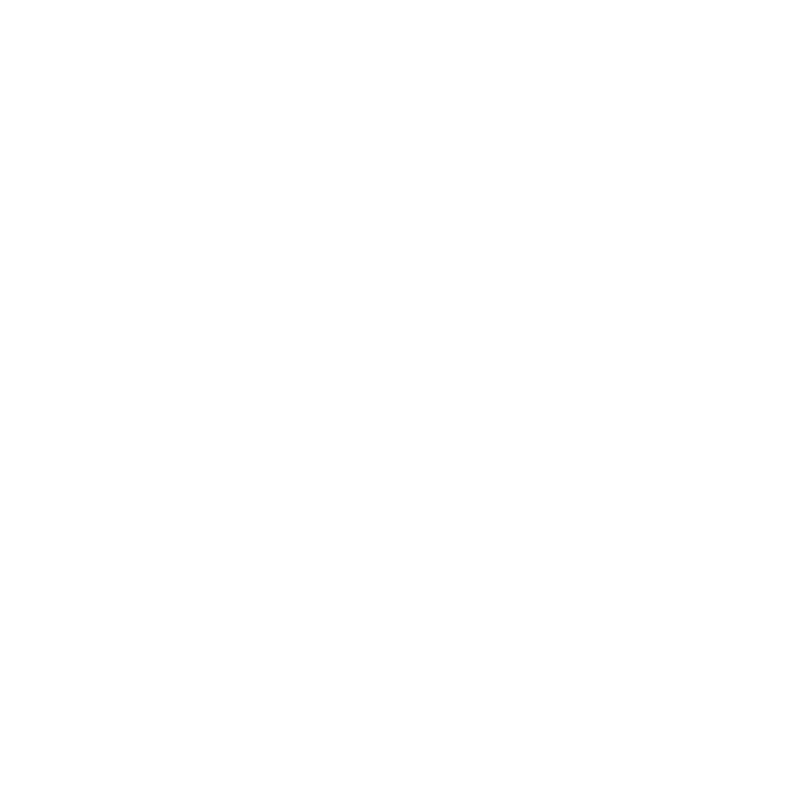

66.0


<IPython.core.display.Javascript object>


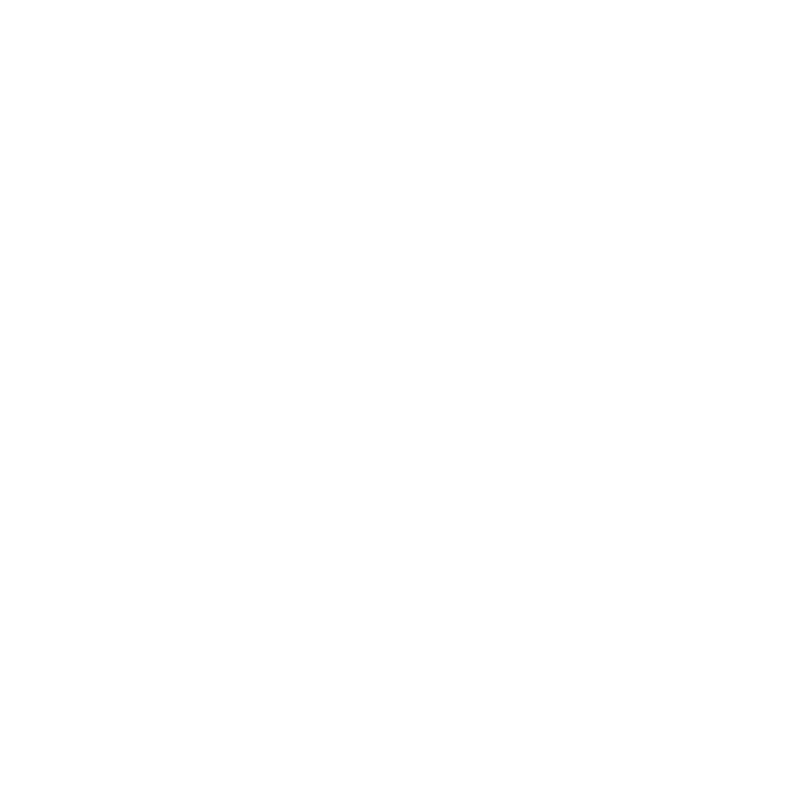

42.0


<IPython.core.display.Javascript object>


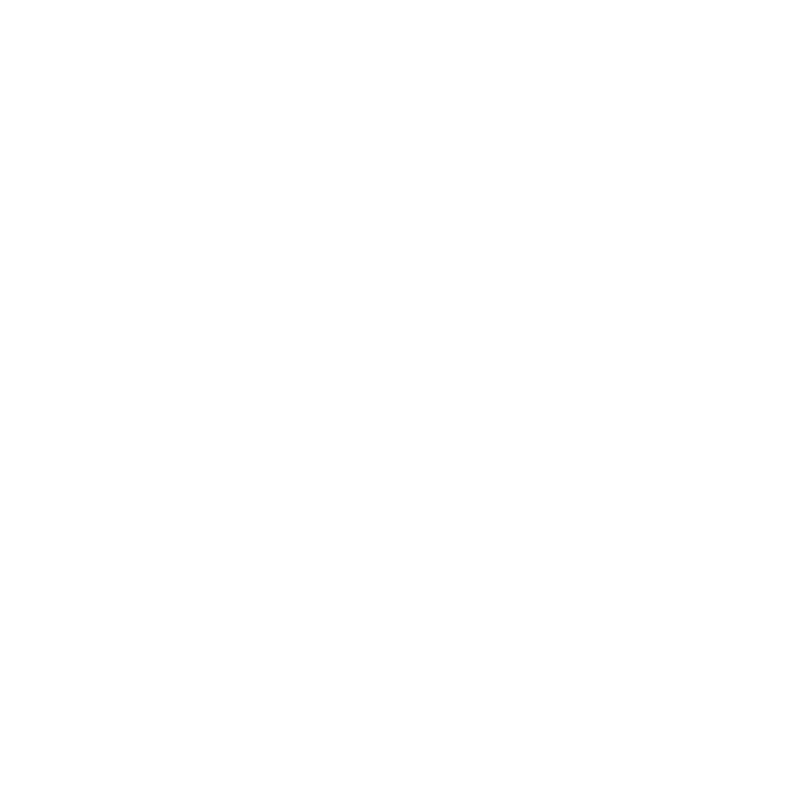

17.0


<IPython.core.display.Javascript object>


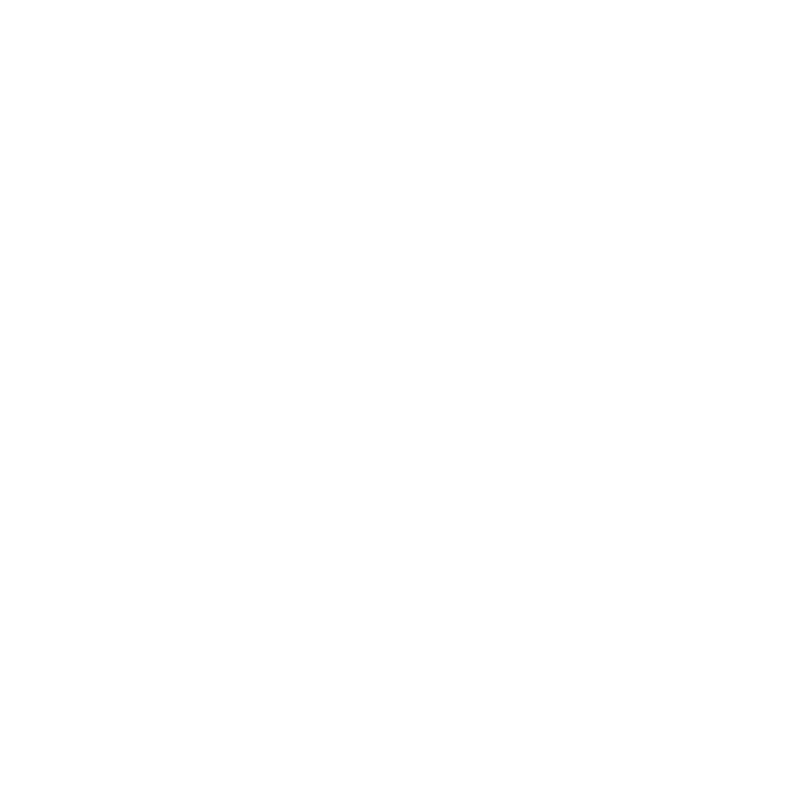

24.0


<IPython.core.display.Javascript object>


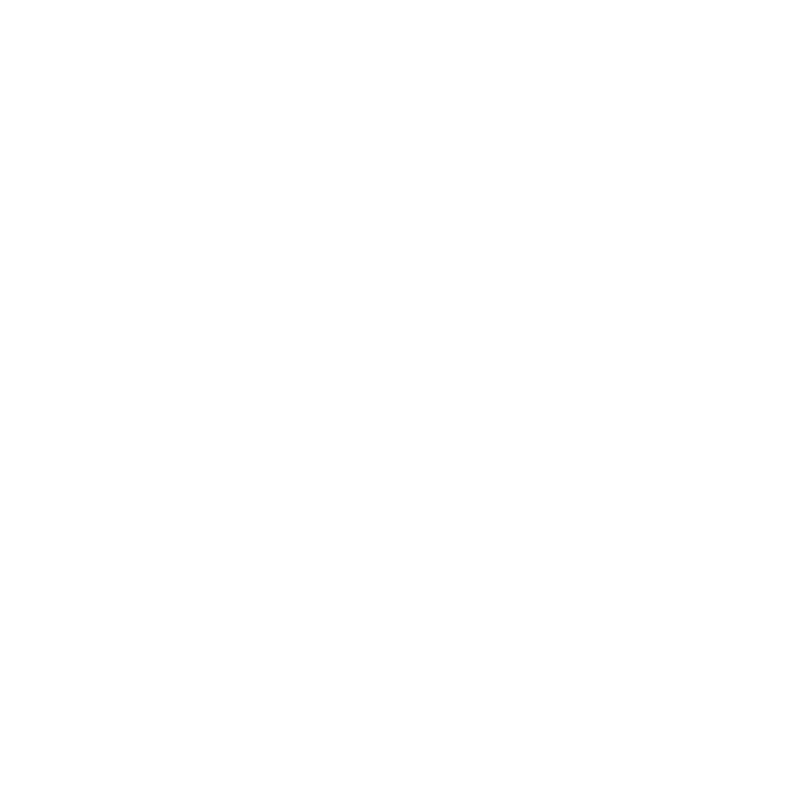

54.0


<IPython.core.display.Javascript object>


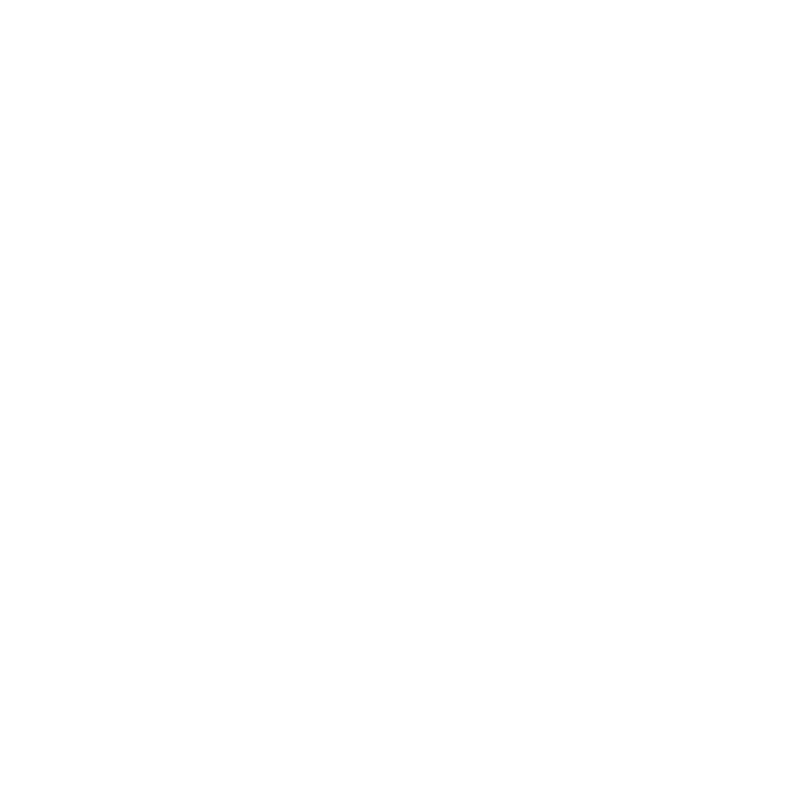

52.0


<IPython.core.display.Javascript object>


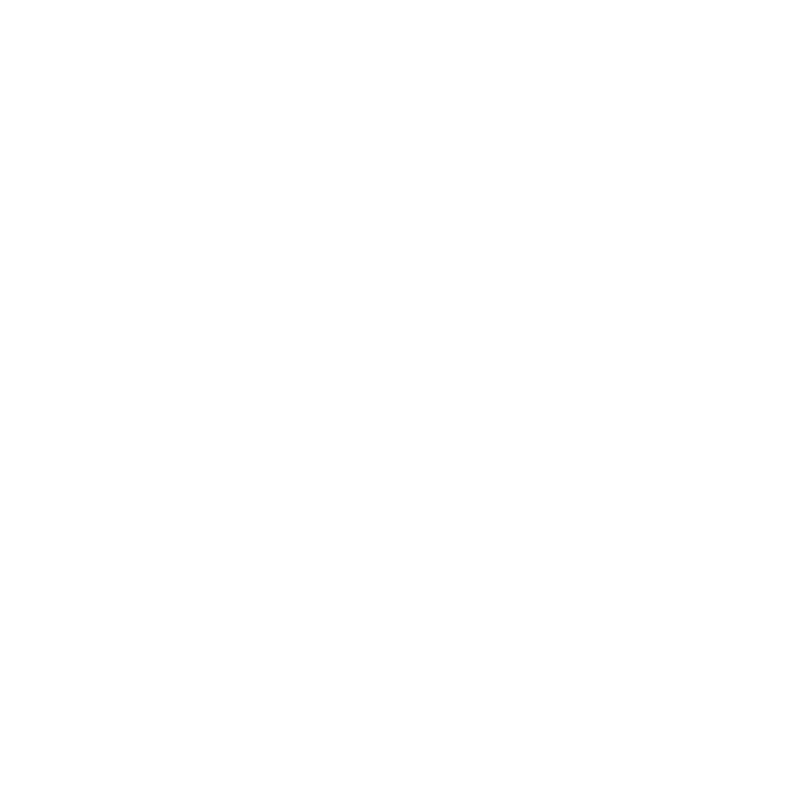

26.0


<IPython.core.display.Javascript object>


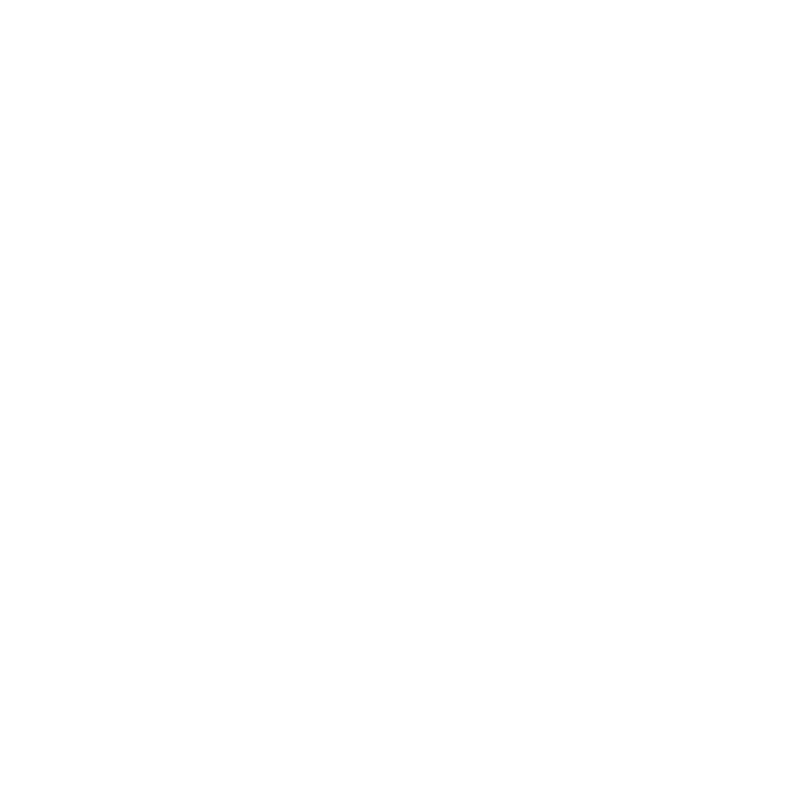

15.0


<IPython.core.display.Javascript object>


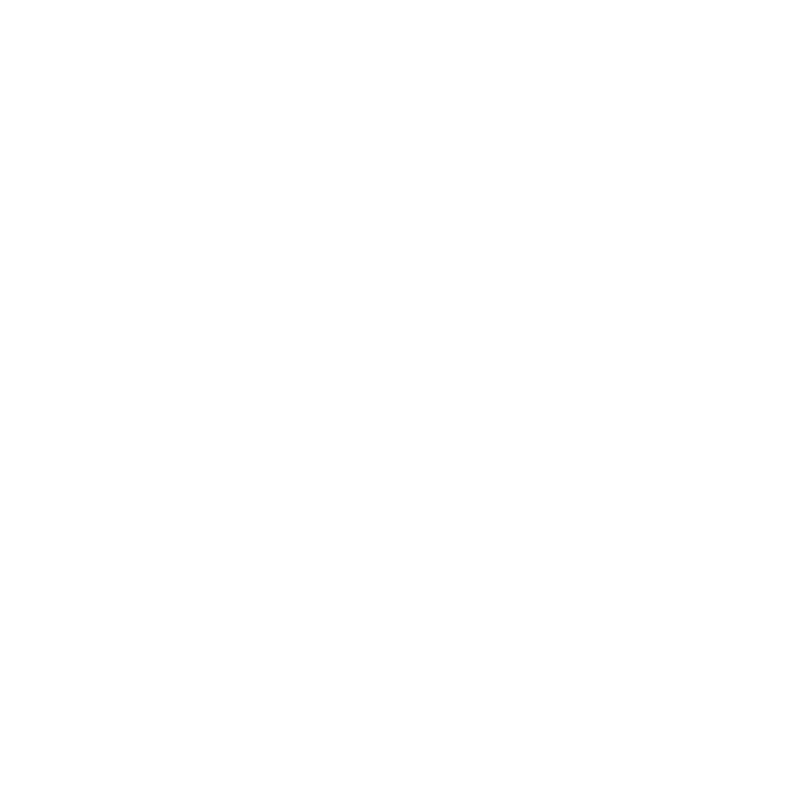

93.0


<IPython.core.display.Javascript object>


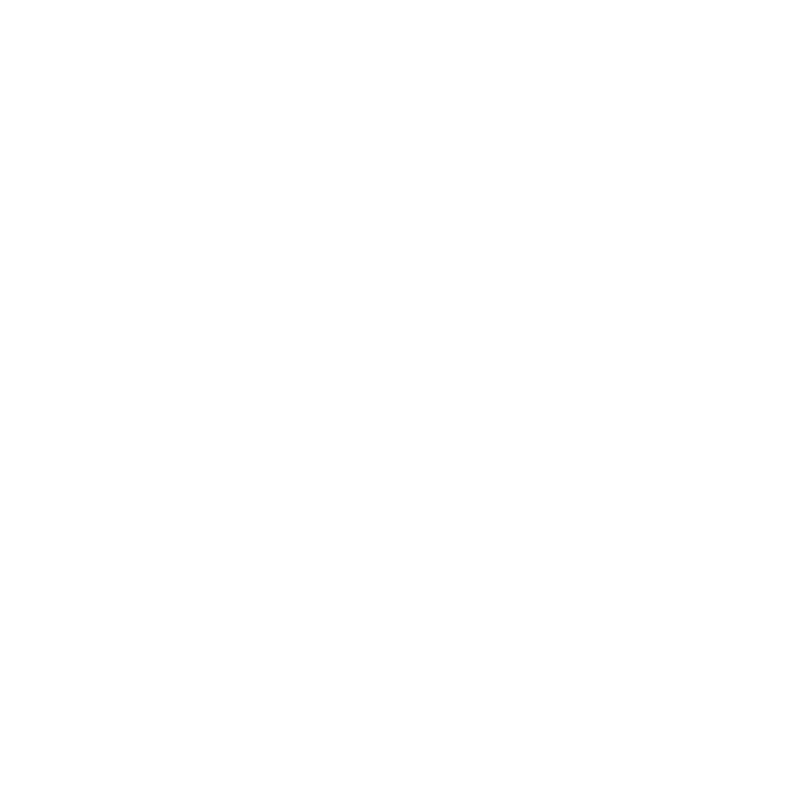

18.0


<IPython.core.display.Javascript object>


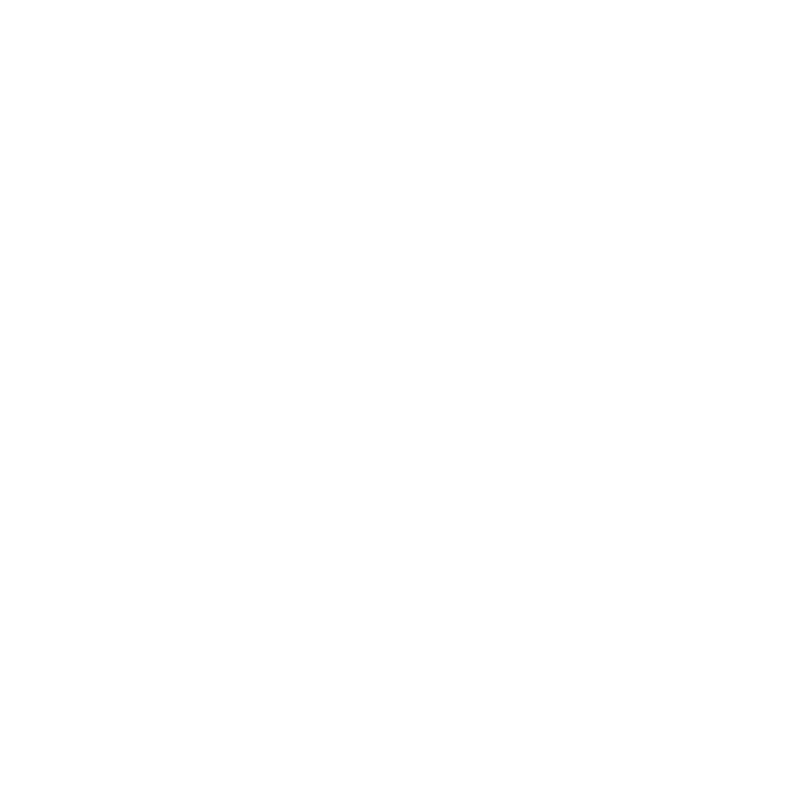

15.0


<IPython.core.display.Javascript object>


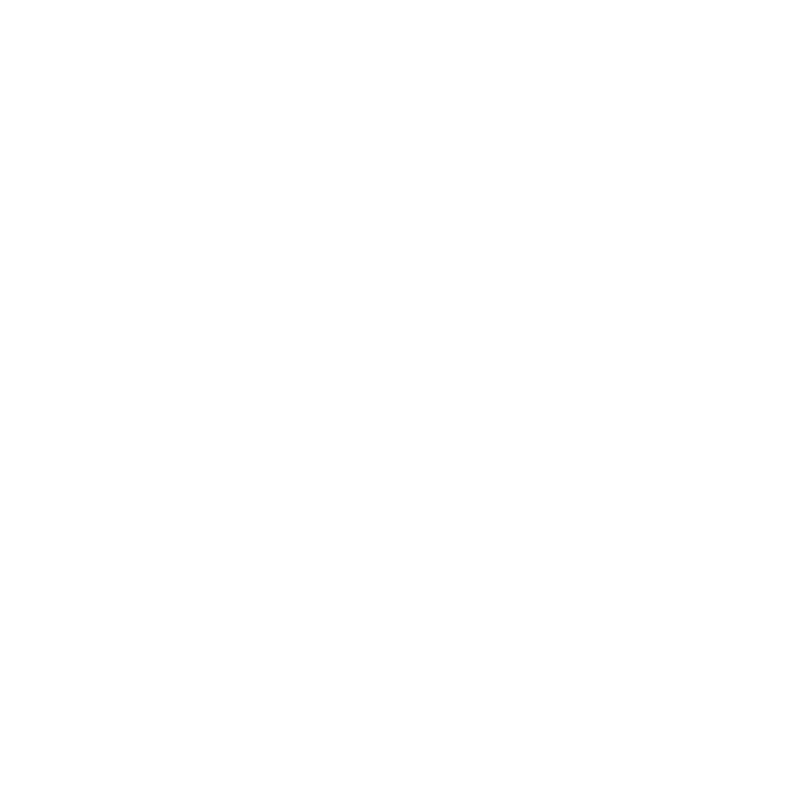

54.0


<IPython.core.display.Javascript object>


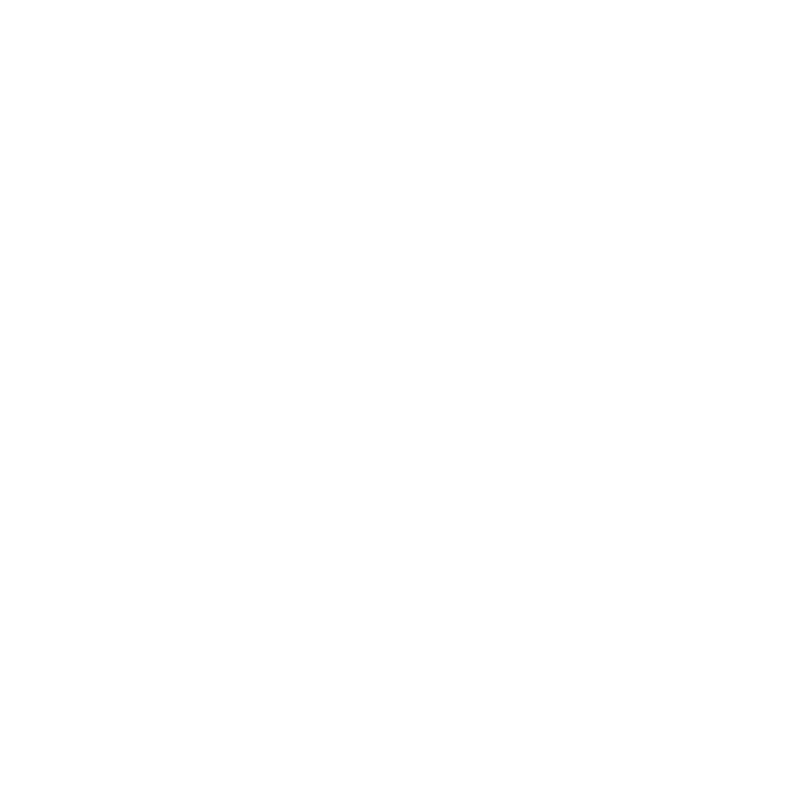

38.0


<IPython.core.display.Javascript object>


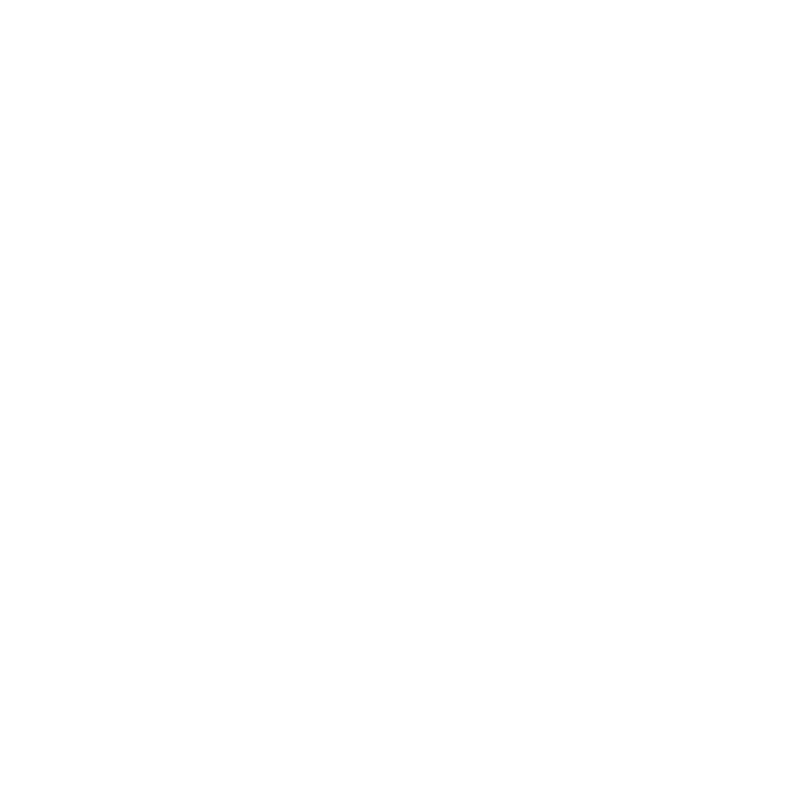

15.0


<IPython.core.display.Javascript object>


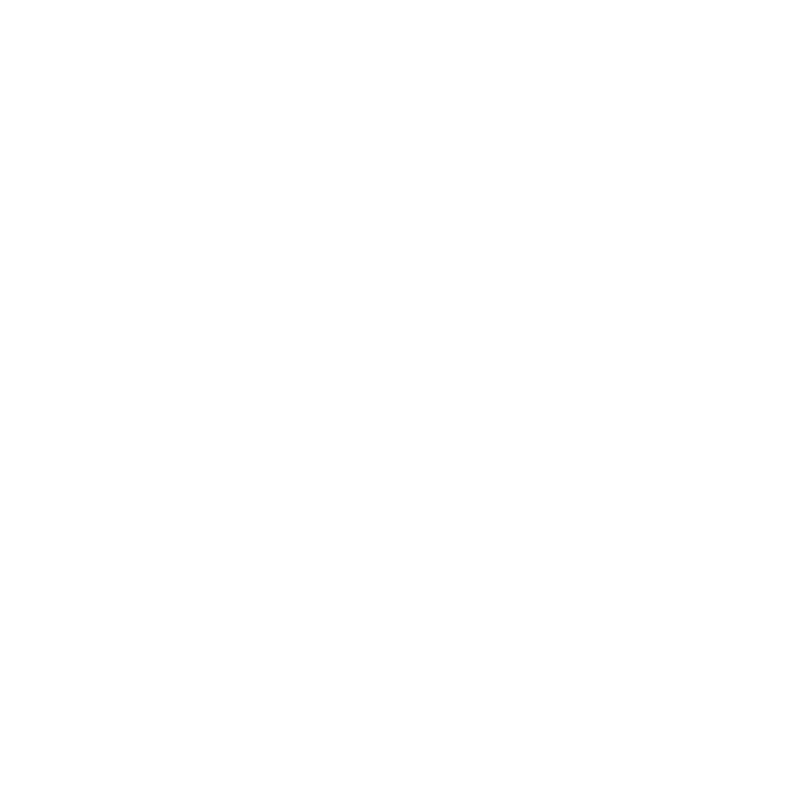

57.0


<IPython.core.display.Javascript object>


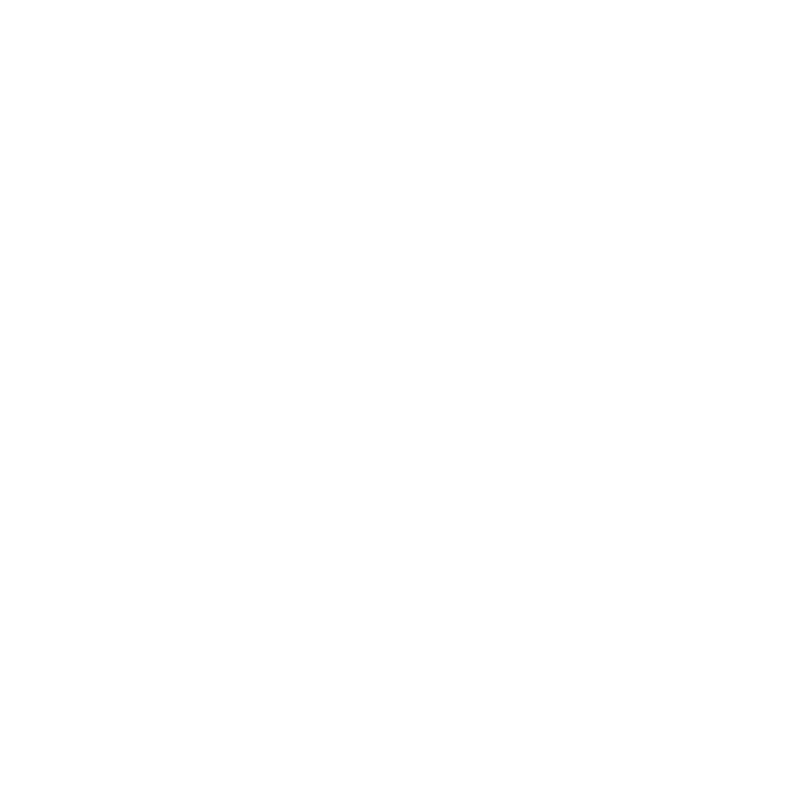

54.0


<IPython.core.display.Javascript object>


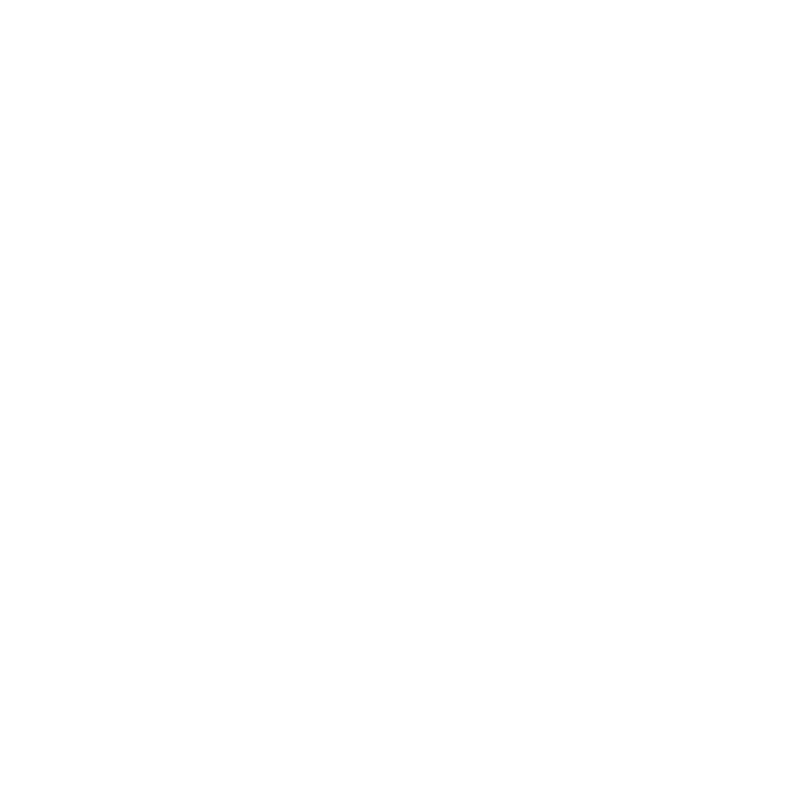

73.0


<IPython.core.display.Javascript object>


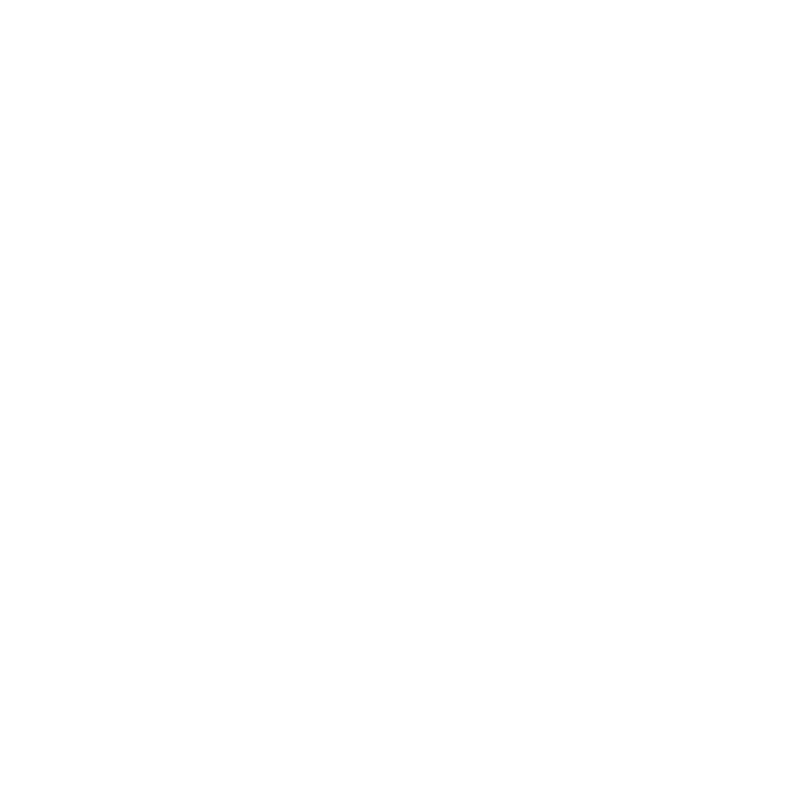

63.0


<IPython.core.display.Javascript object>


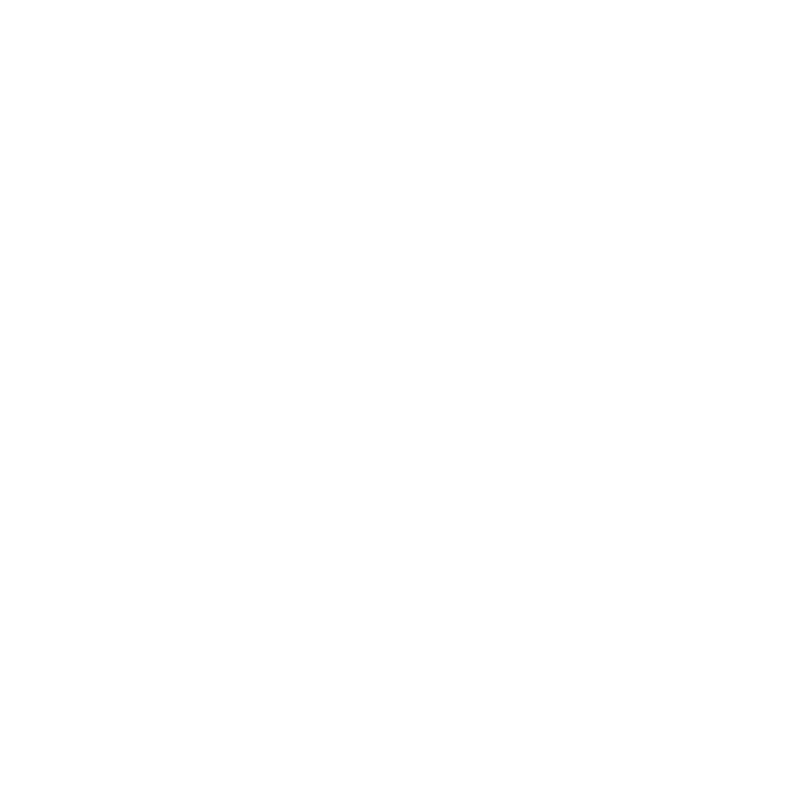

26.0


<IPython.core.display.Javascript object>


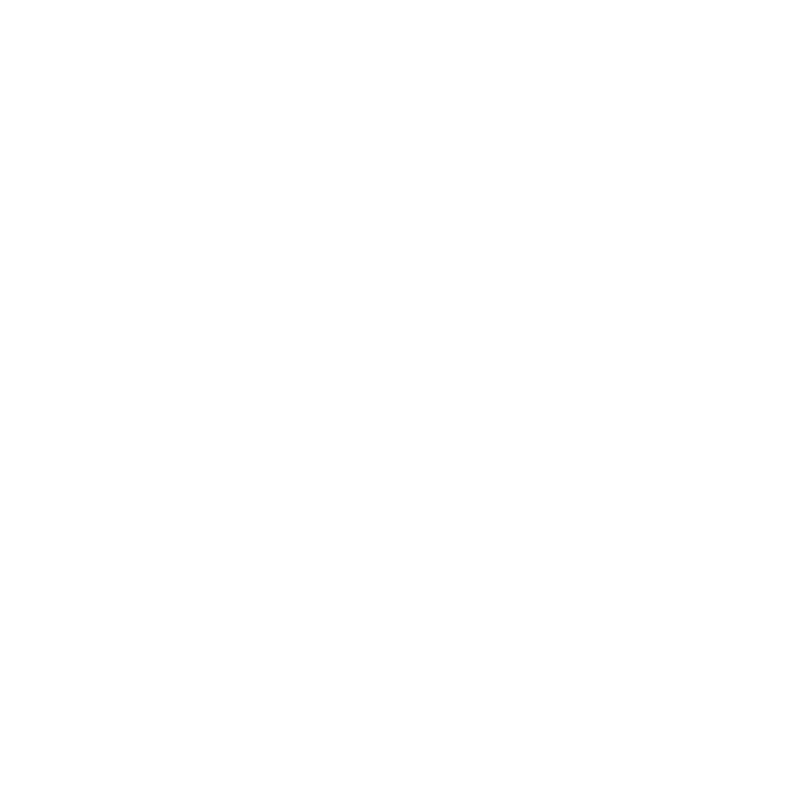

30.0


<IPython.core.display.Javascript object>


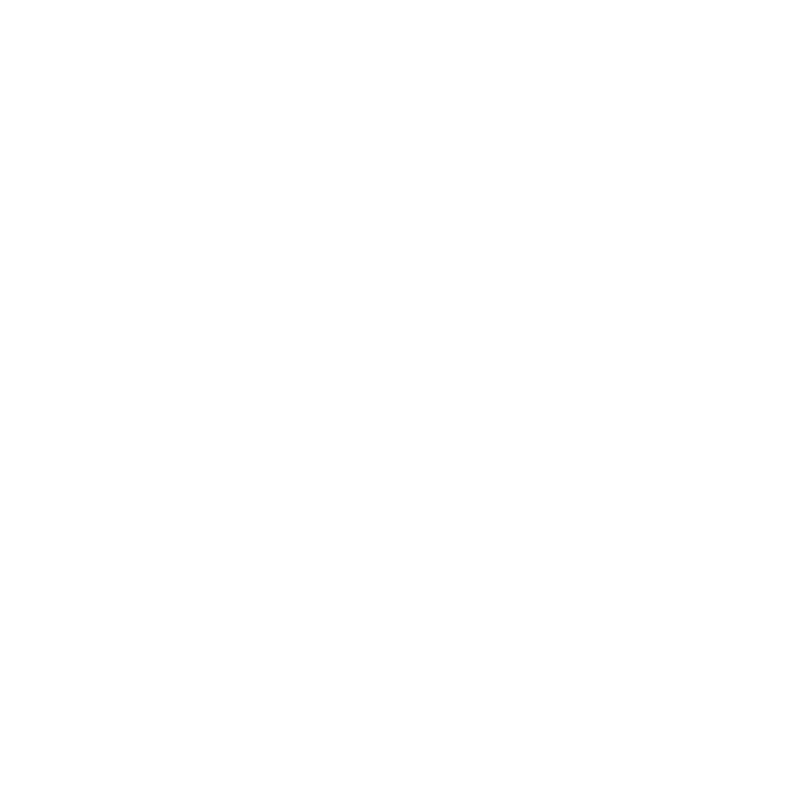

59.0


<IPython.core.display.Javascript object>


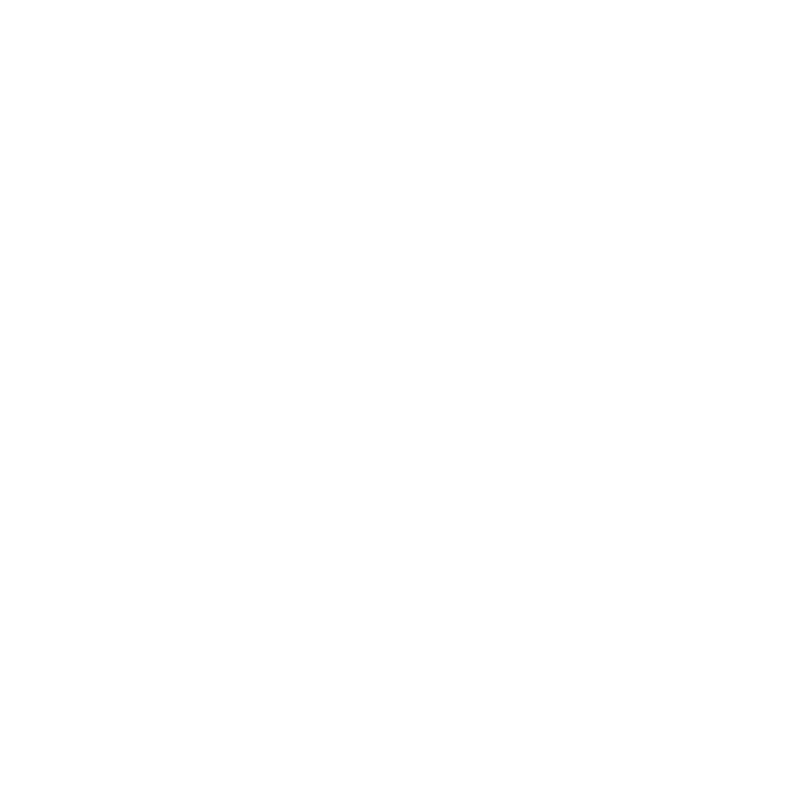

25.0


<IPython.core.display.Javascript object>


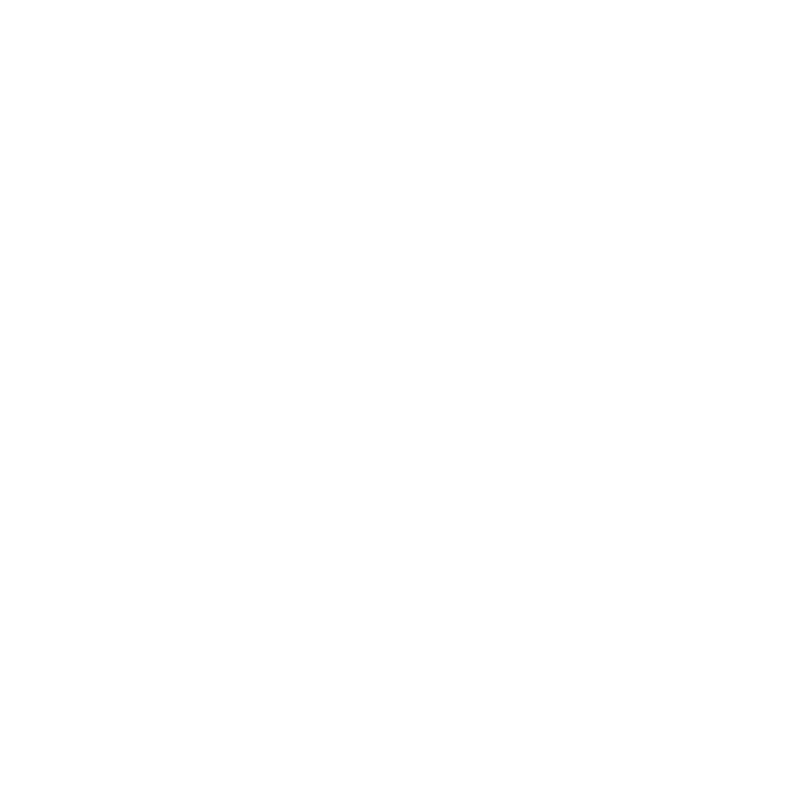

25.0


<IPython.core.display.Javascript object>


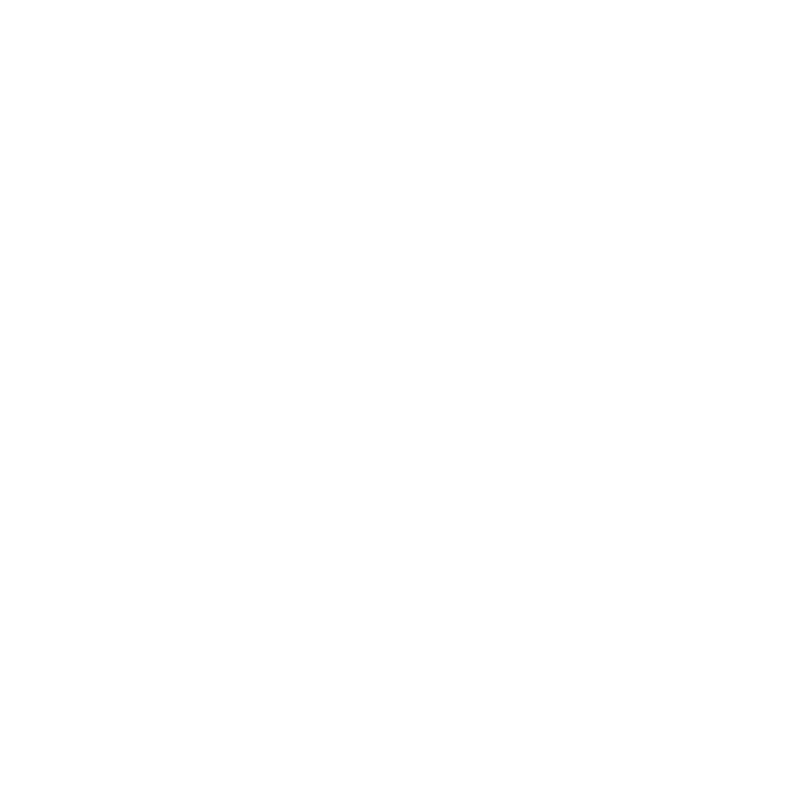

-761.0


<IPython.core.display.Javascript object>


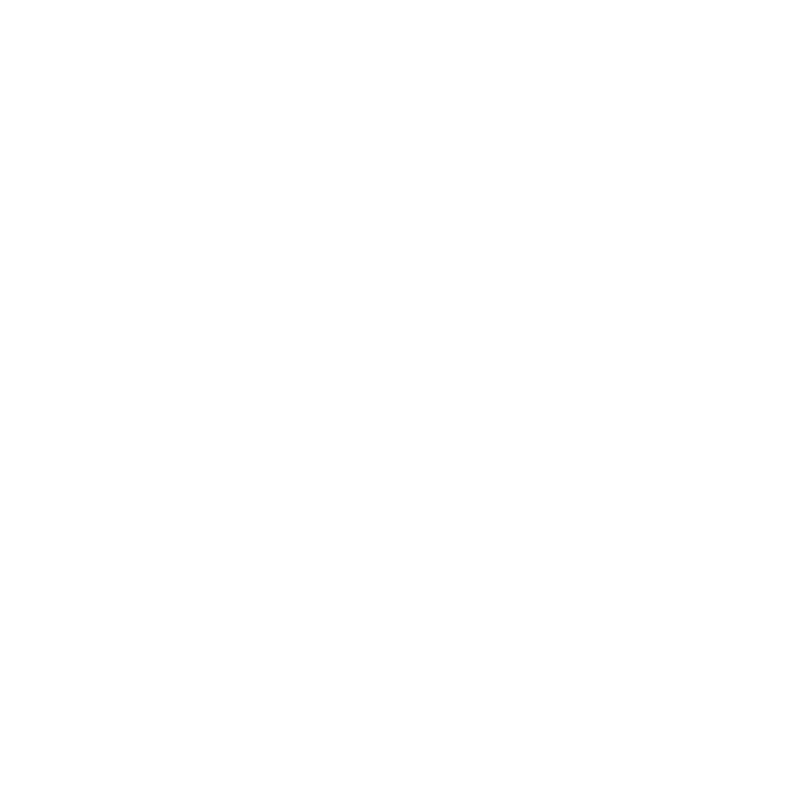

25.841064000000003


<IPython.core.display.Javascript object>


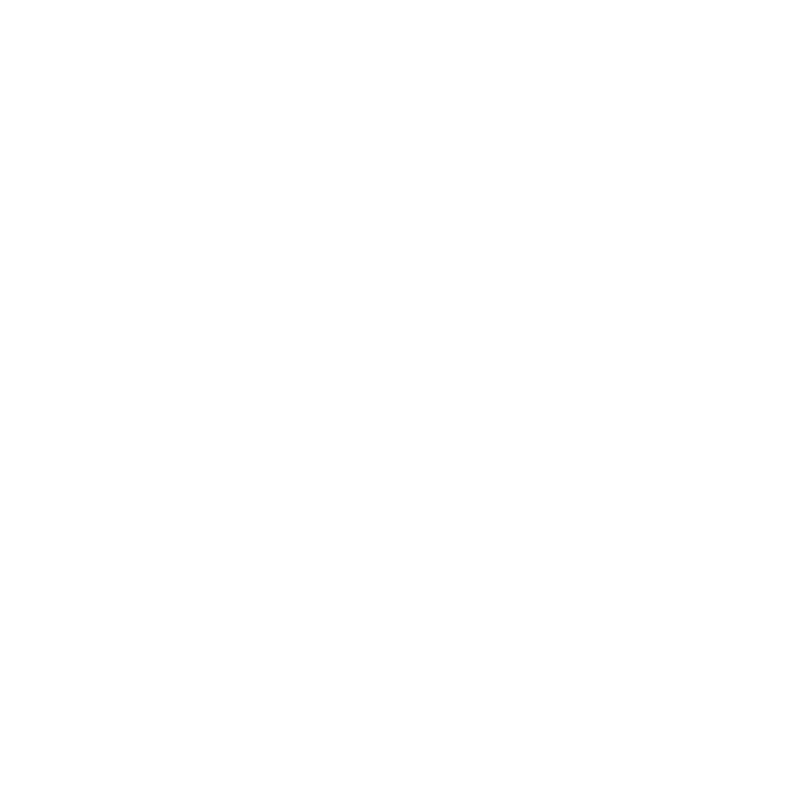

57.34120899999999


<IPython.core.display.Javascript object>


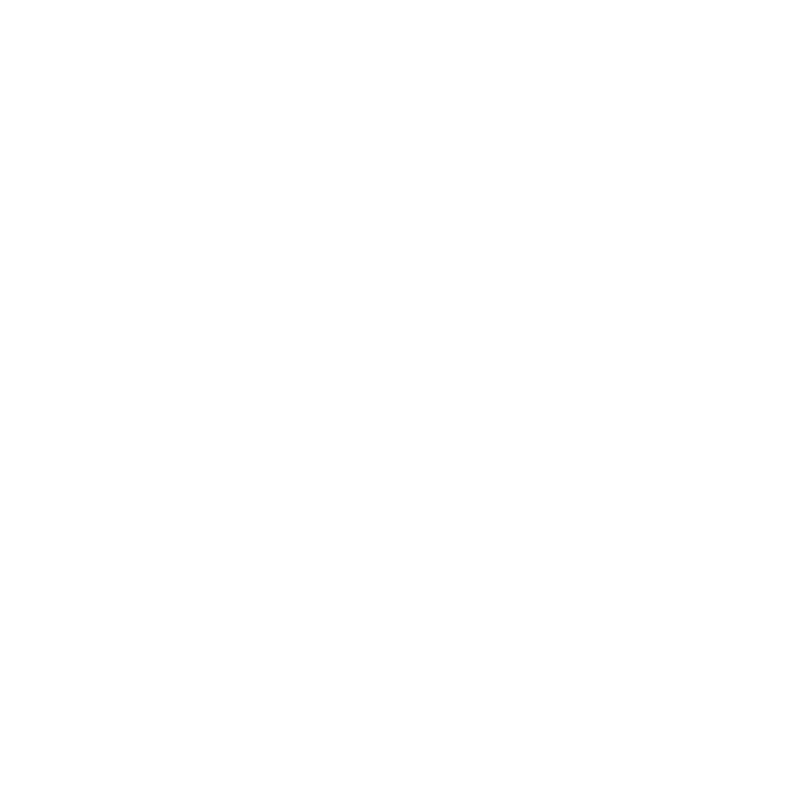

42.0


<IPython.core.display.Javascript object>


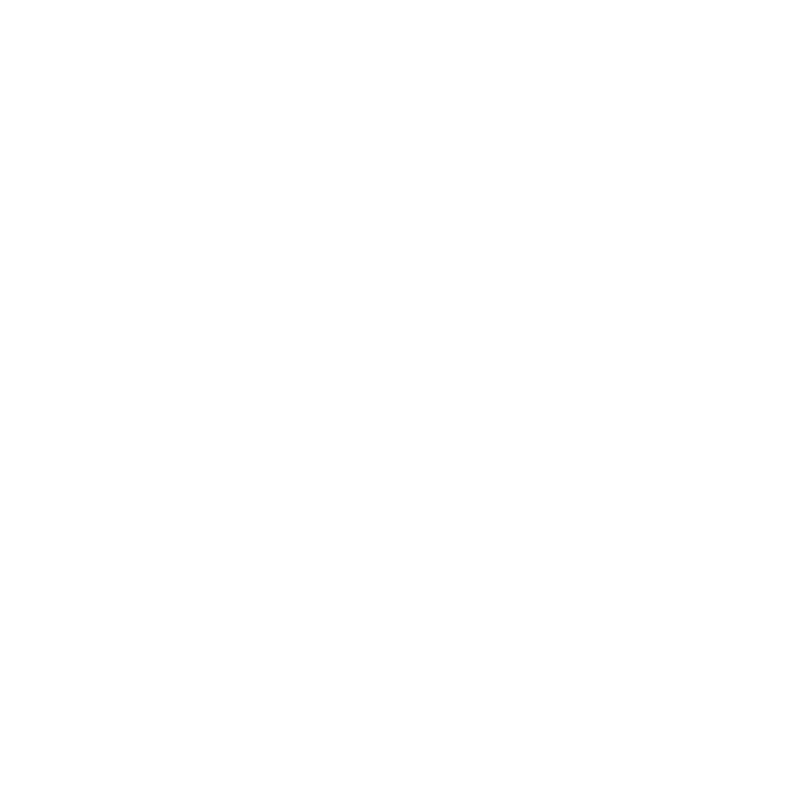

96.0


<IPython.core.display.Javascript object>


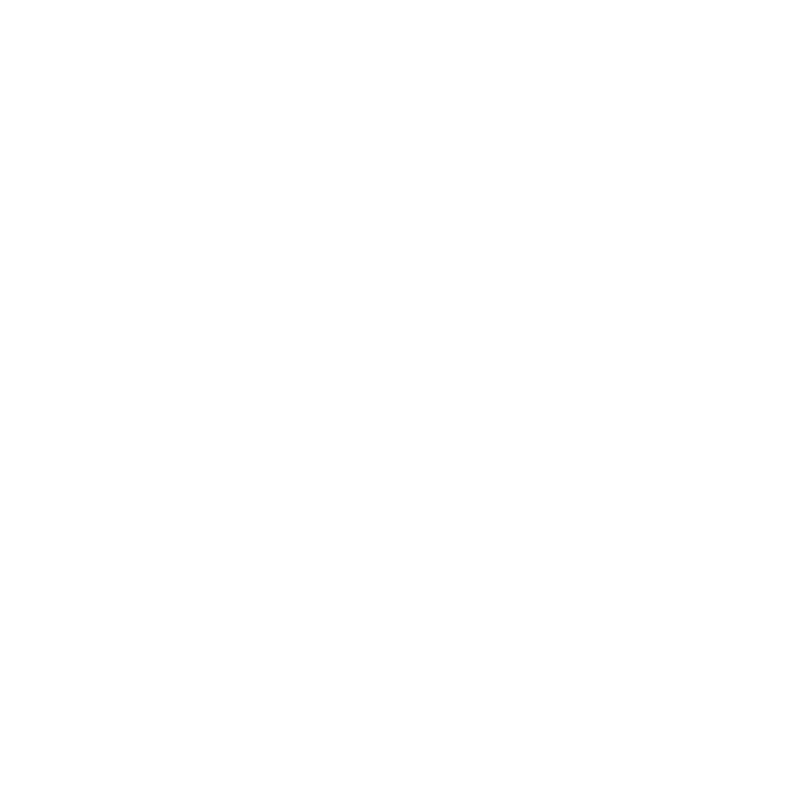

32.0


<IPython.core.display.Javascript object>


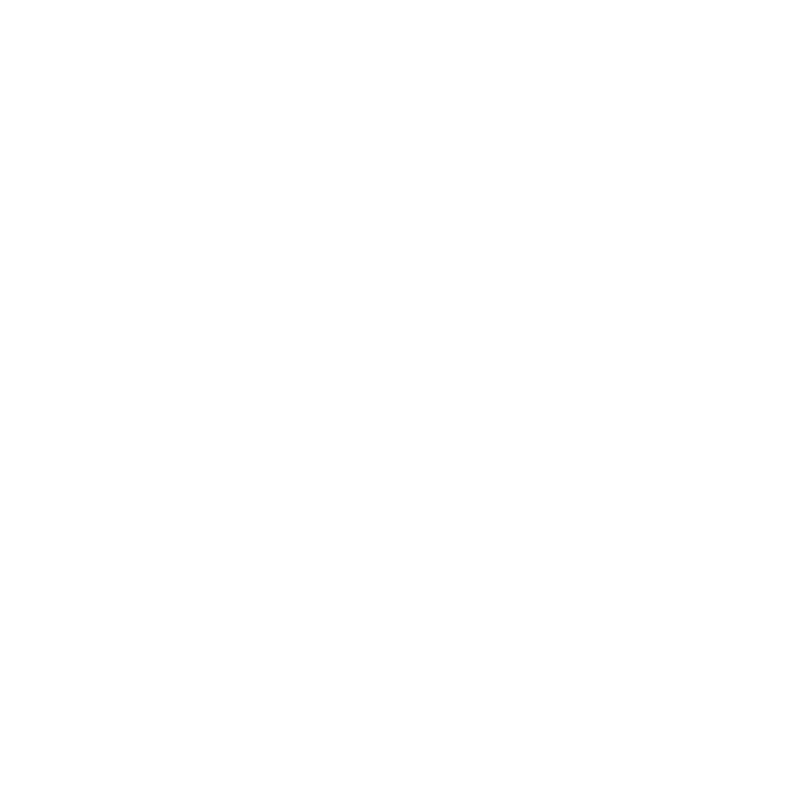

12.0


<IPython.core.display.Javascript object>


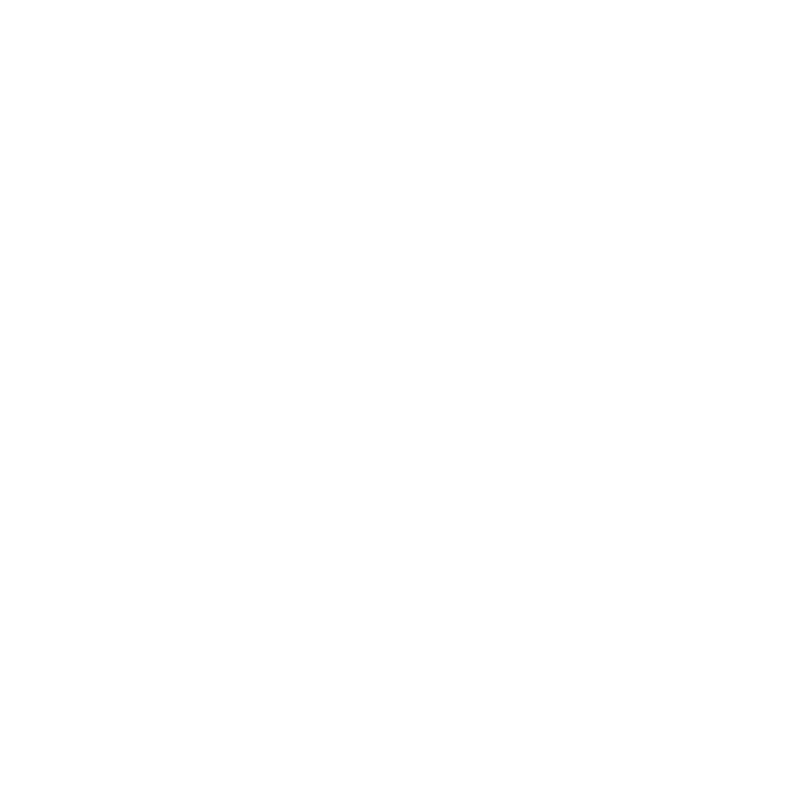

54.0


<IPython.core.display.Javascript object>


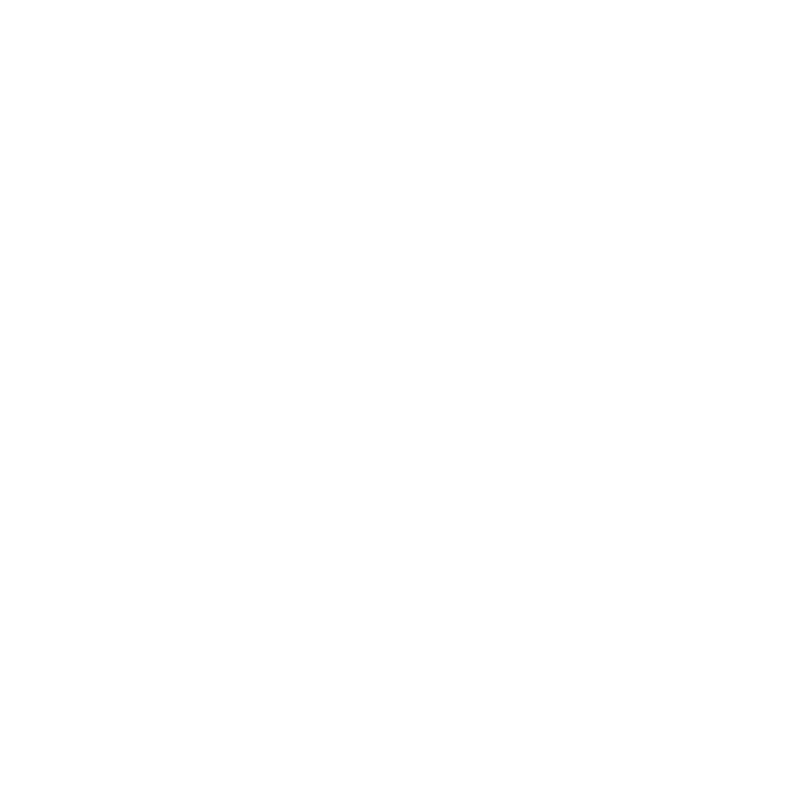

60.0


<IPython.core.display.Javascript object>


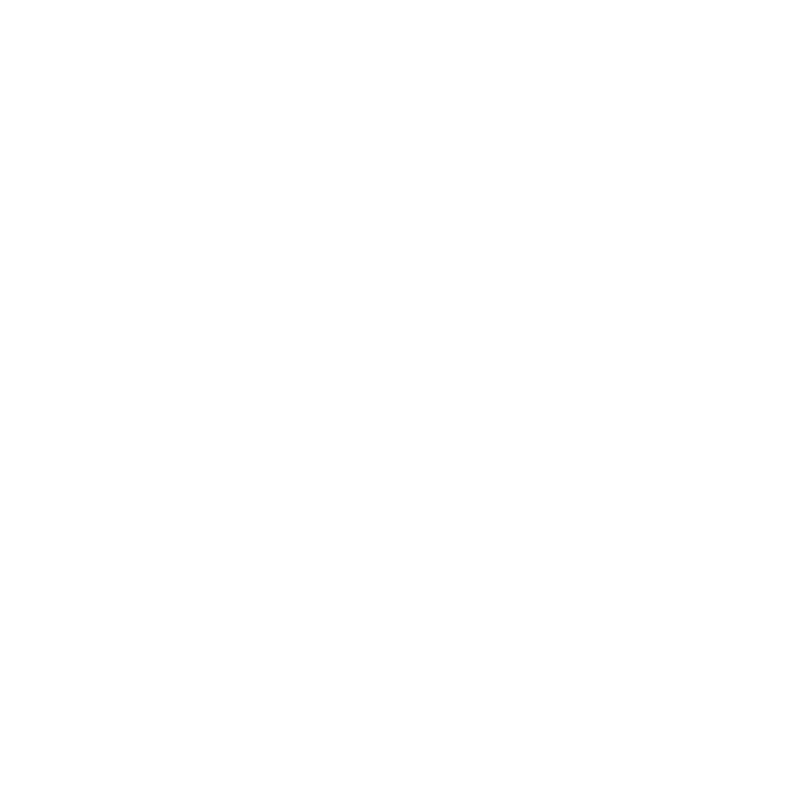

58.0


<IPython.core.display.Javascript object>


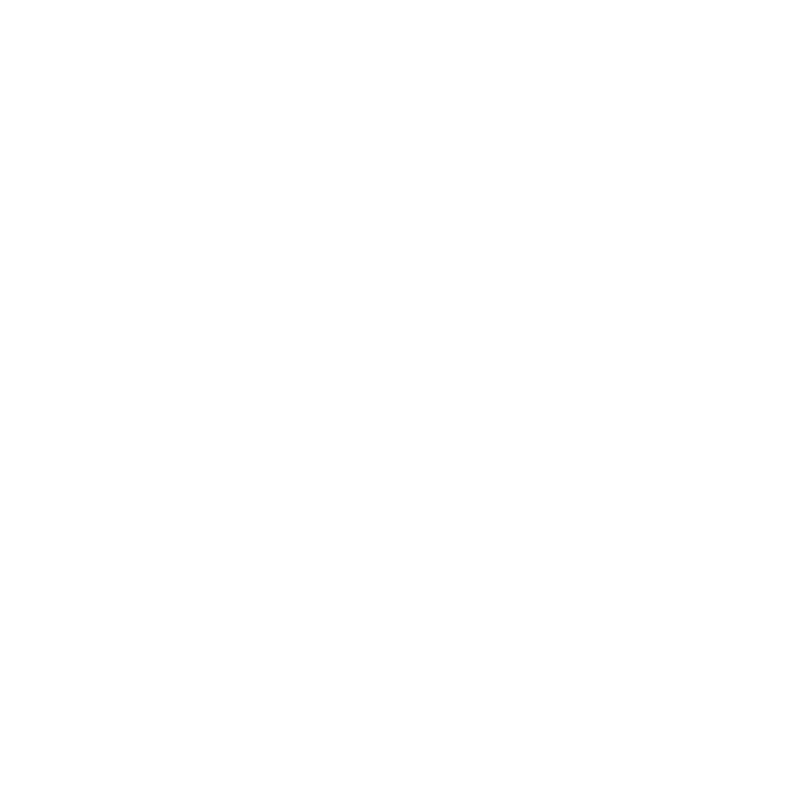

15.0


<IPython.core.display.Javascript object>


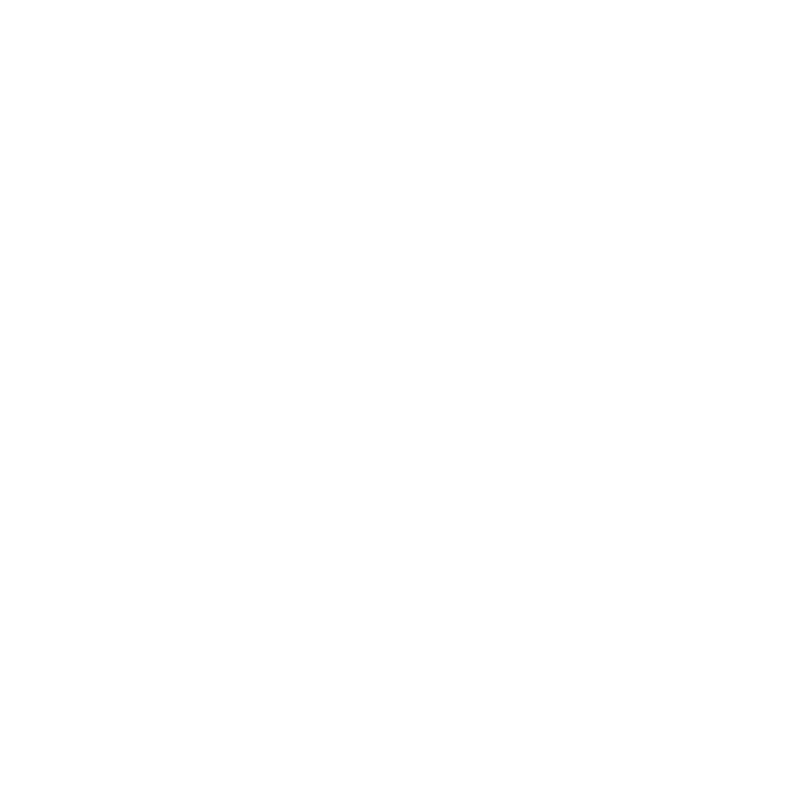

36.0


<IPython.core.display.Javascript object>


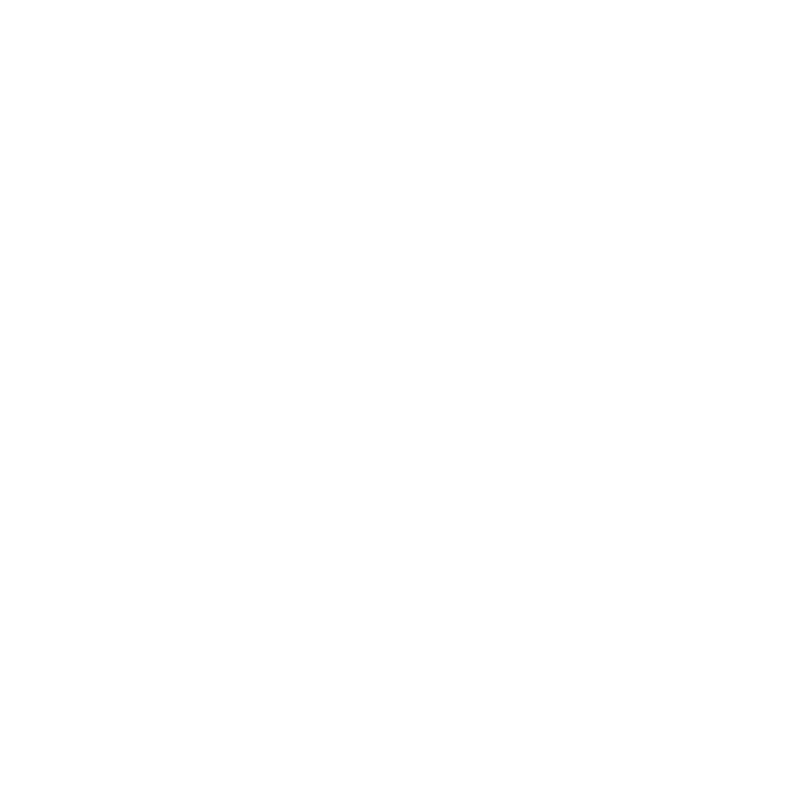

45.0


<IPython.core.display.Javascript object>


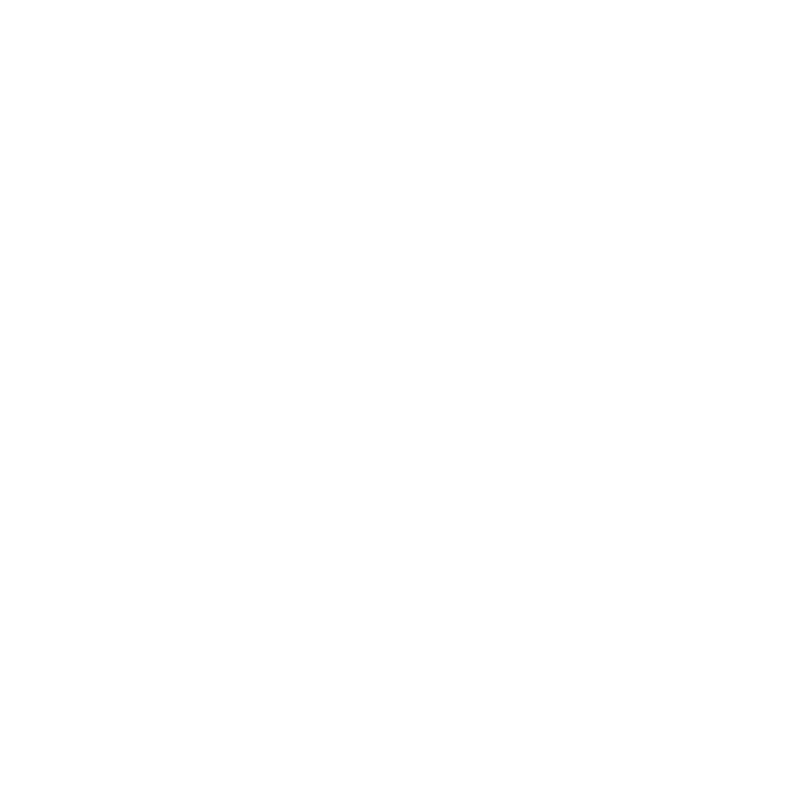

24.0


<IPython.core.display.Javascript object>


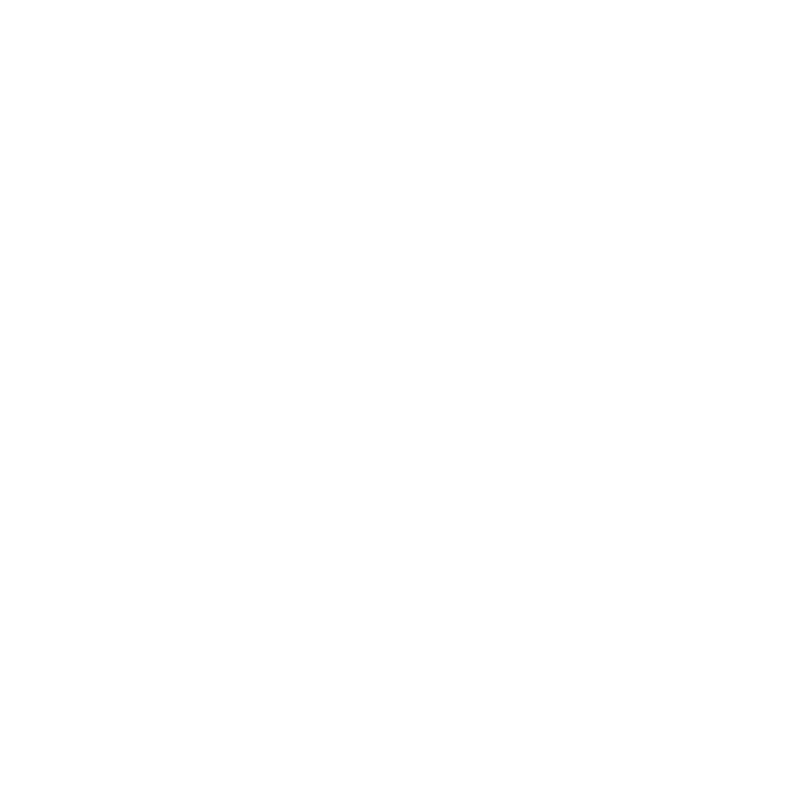

24.0


<IPython.core.display.Javascript object>


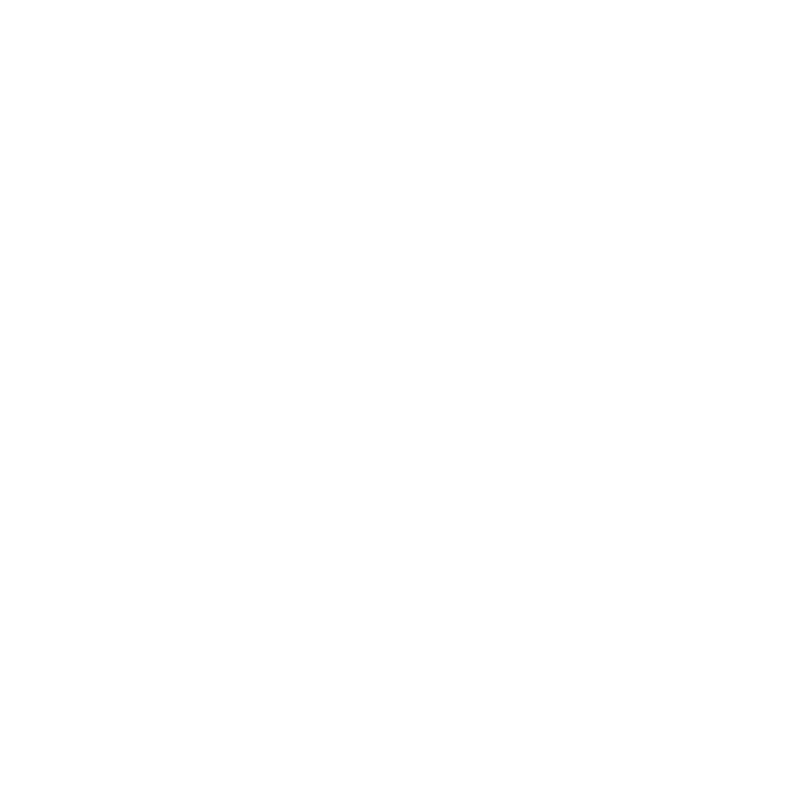

21.0


<IPython.core.display.Javascript object>


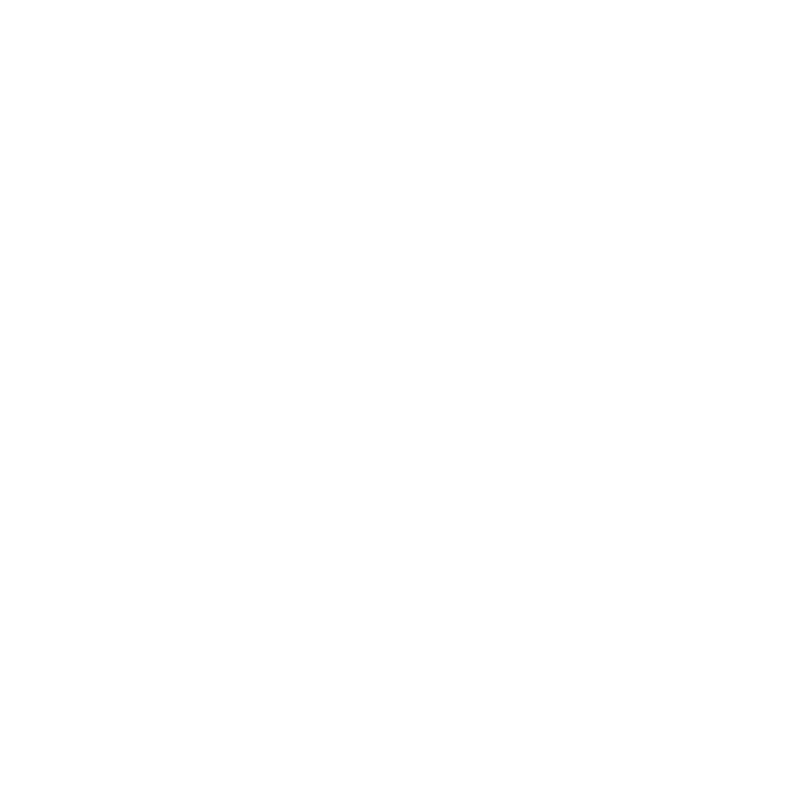

21.0


<IPython.core.display.Javascript object>


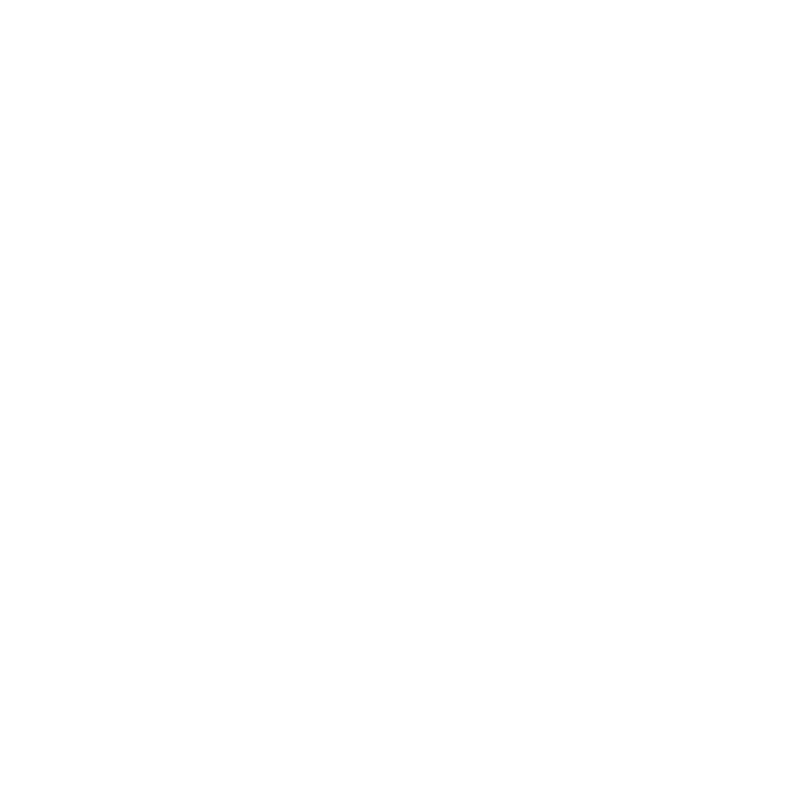

31.0


<IPython.core.display.Javascript object>


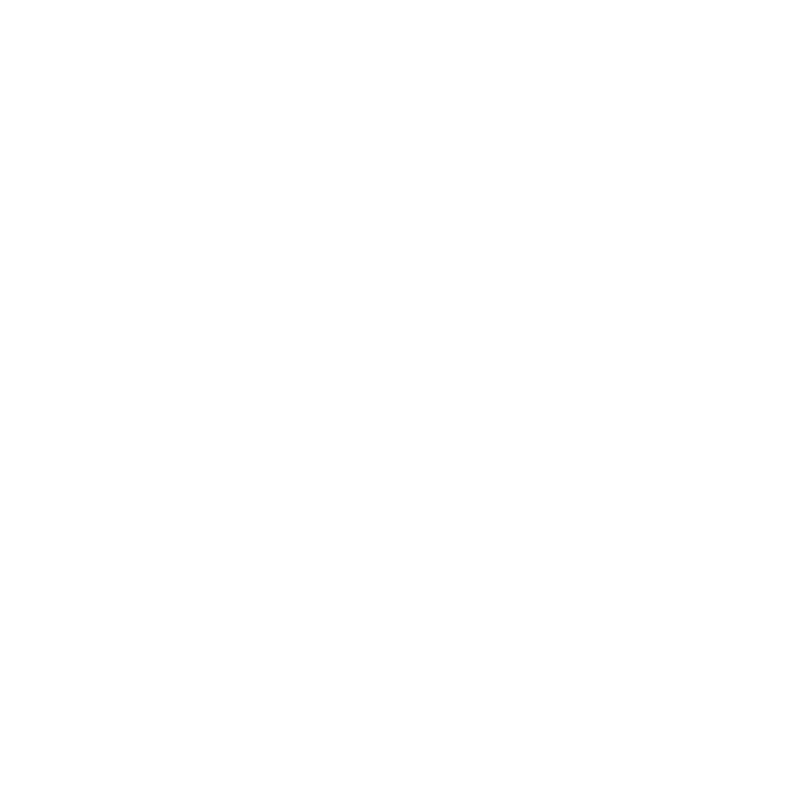

36.0


<IPython.core.display.Javascript object>


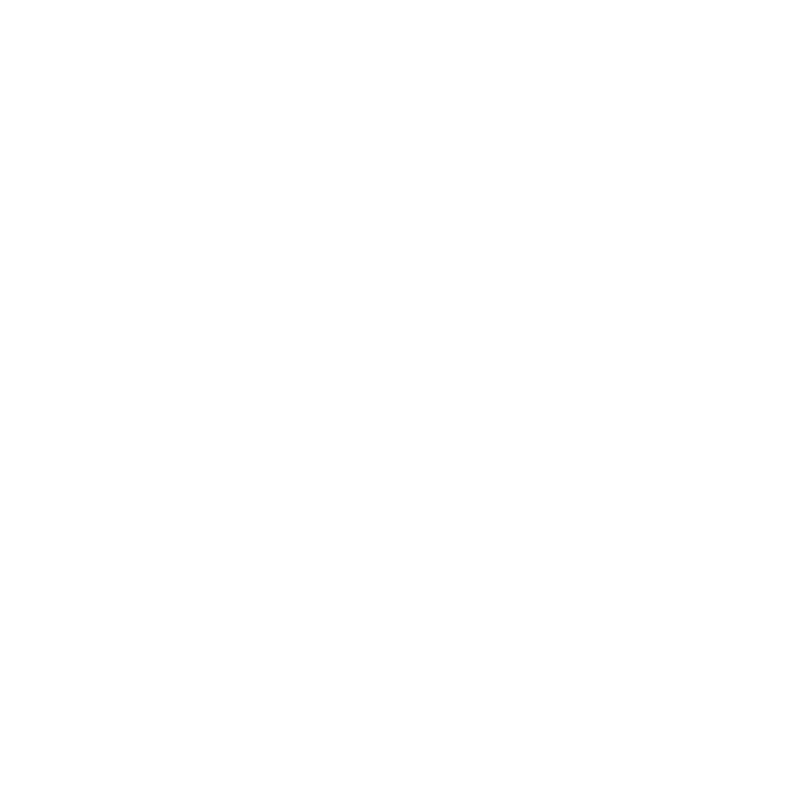

13.0


<IPython.core.display.Javascript object>


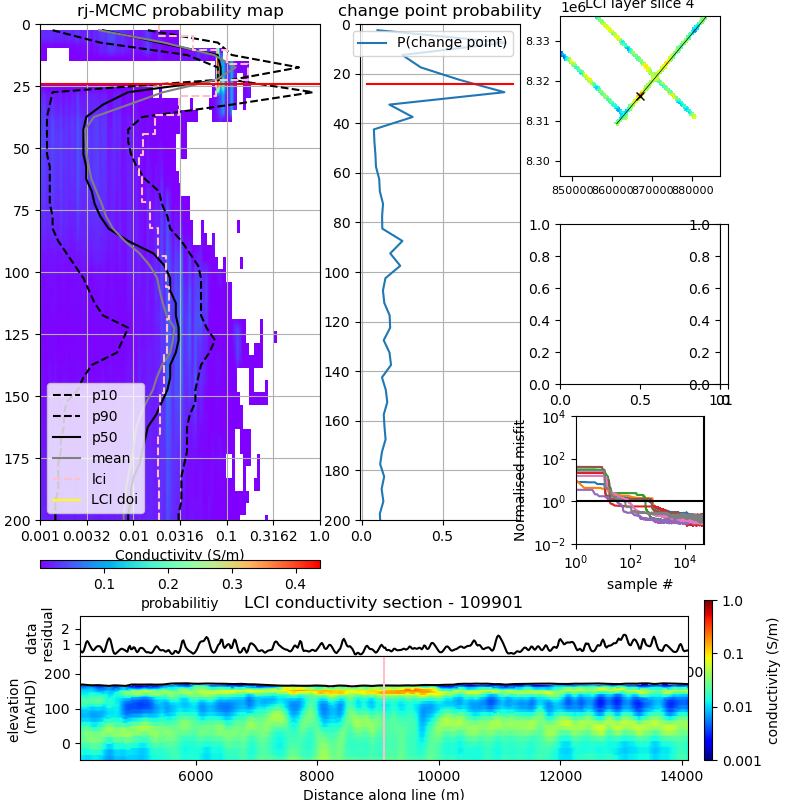

24.0


In [200]:
for i in range(len(points)):
    plt.close('all')

    # define our point from the points array using the index i
    point_index = points[i]

    # Extract the data from the netcdf data
    D = netcdf_utils.extract_rj_sounding(rj, lci, point_index)


    distance = np.round(distances[i],1)
    # create the figure
    fig, ax_array = plots.pmap_plot(D, pmap_kwargs, surface, lci)

    plot_K_depth(bore_ind[i])

    # save the plot
    outfile = os.path.join("/home/ubuntu", "pmap_rj_point_" + str(point_index) + "_" + gdf.iloc[bore_ind[i]]['BORE_NO'] + '_' + str(distance) +'m.png')
    
    plt.savefig(outfile)


# AusAEM

In [3]:
aem_nc_path = infile = "../../workshop_data/AusAEM/AusAEM_NT_galeisbstdem.nc"

aaem = aem_utils.AEM_inversion(name = 'AusAEM (galeisbstdem)',
                               inversion_type = 'deterministic',
                               netcdf_dataset = netCDF4.Dataset(aem_nc_path))

In [4]:
aaem.data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Dataset read from ASEG-GDF file galeisbs_vector_sum_point_located_NT.dat
    Conventions: CF-1.6,ACDD-1.3
    featureType: trajectory
    geospatial_vertical_min: 0.06
    geospatial_vertical_max: 1316.91
    geospatial_vertical_units: m
    geospatial_vertical_resolution: point
    geospatial_vertical_positive: up
    history: Converted from ASEG-GDF file galeisbs_vector_sum_point_located_NT.dat using definitions file galeisbs_vector_sum_point_located_NT.dfn
    date_created: 2020-08-17T16:23:07.305466
    geospatial_east_resolution: point
    geospatial_north_resolution: point
    geospatial_east_min: 177812.703125
    geospatial_east_max: 824312.1875
    geospatial_east_units: m
    geospatial_north_min: 7339038.0
    geospatial_north_max: 8250081.0
    geospatial_north_units: m
    keywords: geophysics, airborne, AEM, conductivity
    geospatial_bounds: POLYGON((135.1500 -24.0608, 134.1

In [5]:
infile = r"/home/ubuntu/workshop_data/boreholes/NT_Cretaceous_bores.csv"
df = pd.read_csv(infile)


gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.POINT_X, df.POINT_Y)).dropna().set_crs("EPSG:4283")

# We want to reproject to gda94 zone52

gdf = gdf.to_crs("EPSG:28353")

gdf['easting'] = [gdf['geometry'][i].x for i in range(len(gdf))]
gdf['northing'] = [gdf['geometry'][i].y for i in range(len(gdf))]

In [6]:
bore_coords = gdf[['easting', 'northing']].values

dist,ind = spatial_functions.nearest_neighbours(bore_coords, aaem.coords,
                                           points_required = 1,max_distance = 1000.)
points = ind[np.isfinite(dist)]

distances = dist[np.isfinite(dist)]

bore_ind = gdf[np.isfinite(dist)].index


In [7]:
bore_ind

Int64Index([ 88, 156, 160, 164, 186, 252, 255, 265, 267, 270, 309, 314, 315,
            316, 318, 319, 361, 362, 363, 387, 388, 444, 446, 453, 486, 487,
            496, 497, 499, 505, 506, 507, 508, 543, 545, 560, 567, 568, 569,
            570, 571, 574, 575, 576, 578, 581, 582, 583, 593, 594, 595, 615,
            616, 617, 618, 623, 634, 635, 636, 649, 650, 651, 652, 653, 654,
            666],
           dtype='int64')

In [8]:
line_inds = aaem.data['line_index'][points].data

lines = aaem.data['line'][np.unique(line_inds)].data

In [9]:
lines

array([1010004, 1020003, 1030004, 1040002, 1050003, 1060003, 1070002,
       1080002, 1090002, 1100002, 1110003, 1120002, 1130002, 1140003,
       1150004, 1160002])

In [10]:
import importlib
importlib.reload(spatial_functions)

<module 'spatial_functions' from '../scripts/spatial_functions.py'>

In [11]:
# Now we have the lines we can grid the lci conductivity data onto vertical grids (known as sections)
# this is the easiest way to visualise the AEM conuctivity in 2-dimensions

# Assign the lci variables to grid
grid_vars = ['conductivity', 'phid']

# Define the resolution of the sections
xres, yres = 20., 5.


# Define the output directory if saving the grids as hdf plots

hdf5_dir = "../../workshop_data/AusAEM/hdf5"

# if the directory doesn't exist, then create it
if not os.path.exists(hdf5_dir):
    os.mkdir(hdf5_dir)  

# Gridding takes a few minutes so I pre-gridded them for you. The lci.grid_sections()
# function below will do the gridding for you. Instead we will use the load_sectoin_from_file()
# function, which loads hdf5 files produced using the grid_sections() function


#aaem.grid_sections(variables = grid_vars, lines = lines, xres = xres, yres = yres,
#                  return_interpolated = True, save_hdf5 = True, hdf5_dir = hdf5_dir)


aaem.load_sections_from_file(hdf5_dir, grid_vars)

In [214]:
def K_depth(bore):
    if np.isclose(bore['Cretaceous'],999.):
        depth = bore['Cret_Thick']
    else:
        depth = bore['gLevelSRTM'] - bore['bCretElev']
    return depth
    

def plot_K_depth(ax, bore):
    
    ax.plot(ax.get_xlim(), [depth,depth], c = 'red', label = 'Cretaceous interface')
    depth = K_depth(bore)
    return ax, depth


def AusAEM_fid_plot(ax, cond, depth):
    cond_expanded = np.zeros(shape=2 * len(cond) + 1,
                                 dtype=np.float)

    cond_expanded[1:] = np.repeat(cond, 2)

    depth_expanded = (np.max(depth) + 10) * np.ones(shape=len(cond_expanded),
                                                            dtype=np.float)

    depth_expanded[:-1] = np.repeat(depth, 2)
    
    ax.plot(np.log10(cond_expanded), depth_expanded, c = 'k',
             linestyle = 'solid', label = 'AusAEM profile')
    ax.set_xticklabels([round(10 ** float(x), 4) for x in ax.get_xticks()])
    
    ax.set_ylabel('depth (mBGL)')
    ax.set_xlabel('Conductivity (S/m)')
    ax.grid(which = 'both')
    
    ax.set_ylim(300, 0)
    
    return ax

def dist_2_northticks(ax, section_data):
    north_ticks = ax.get_xticks().copy()

    for i, t in enumerate(north_ticks):
        northing = np.where(np.isclose(section_data['grid_distances'],t))[0]
        if len(northing) > 0:
            north_ticks[i]= northing[0]
        else:
            north_ticks[i]= np.nan

    ax.set_xticklabels(north_ticks)

In [258]:
                   # panel 1 shows phid for a section.
plot_kwargs = {'panel_1': {'color': 'black',
                      'ylabel': 'phid',
                      'legend': False,
                         'buffer': 10000.},
                  # panel 2 shows the ausaem conductivity section
                  'panel_2': {'title': 'LCI conductivity',
                      'max_depth': 250.,
                      'vmin': 0.001,
                      'vmax': 0.5,
                      'cmap': 'jet',
                      'ylabel': 'elevation \n (mAHD)',
                       'buffer': 10000.,
                       'shade_doi': False}}
    
def Aus_AEM_plot(point, bore, save_fig = True):
    plt.close('all')

    fig = plt.figure(figsize = (10,6))

    ax1 = fig.add_axes([0.55, 0.62, 0.2, 0.3])
    ax2 = fig.add_axes([0.1, 0.4, 0.8, 0.1])
    ax3 = fig.add_axes([0.1, 0.1, 0.8, 0.3])
    ax4 = fig.add_axes([0.25, 0.62, 0.2, 0.3])

    cbar_ax = fig.add_axes([0.8, 0.6, 0.01, 0.3])

    cond = aaem.data['conductivity'][point]

    line_ind = aaem.data['line_index'][point]
    line = int(aaem.data['line'][line_ind].data)

    swl_depth = bore['WATERLEVEL']

    layer_top_depth = aaem.data['layer_top_depth'][point]

    fid = aaem.data['fiducial'][point]
    easting = aaem.data['easting'][point]
    northing = aaem.data['northing'][point]
    elevation = aaem.data['elevation'][point]

    ax1 = AusAEM_fid_plot(ax1, cond, layer_top_depth)

    # Plot the borehole cretaceous interpretation

    ax1, K_depth = plot_K_depth(ax1, bore)
    

    if swl_depth > 0.01:

        ax1.plot(ax1.get_xlim(), [swl_depth,swl_depth],
                c = 'blue', label = 'SWL')


    ax1.legend()
    res1 = plots.plot_single_line(ax2, aaem.section_data[line],
                                 'phid', plot_kwargs['panel_1'])

    ax2.set_title('AusAEM conductivity section - ' + str(line))

    dist = spatial_functions.xy_2_var(aaem.section_data[line],
                                      np.array([[easting, northing]]),
                                      'grid_distances')


    # Find distance along the lci section


    im2 = plots.plot_grid(ax3, aaem.section_data[line], 'conductivity',
                              panel_kwargs = plot_kwargs['panel_2'])

    ax3.plot([dist, dist], [-500, 500], 'pink')
    ax3.set_xlabel("Distance along line (m)")

    ax2.set_xlim(dist - plot_kwargs['panel_1']['buffer'],
                 dist + plot_kwargs['panel_1']['buffer'])
    ax3.set_xlim(dist - plot_kwargs['panel_2']['buffer'], 
                 dist + plot_kwargs['panel_2']['buffer'])

    ax3.plot([dist],[elevation - K_depth], 'k+')

    dist_2_northticks(ax3, aaem.section_data[line])
    ax3.set_xlabel('northing')

    # For axis four we will create the AEM lines plotted

    for item in aaem.section_data.keys():
        if item == line:
            colour = 'blue'
        else:
            colour = 'k'
        ax4.plot(aaem.section_data[item]['easting'], aaem.section_data[item]['northing'],
                  c = colour)
    ax4.plot([easting], [northing], 'r+')

    cb = fig.colorbar(im2, cax=cbar_ax, orientation='vertical')

    cb.ax.set_yticklabels([round(10 ** x, 4) for x in cb.get_ticks()])
    cb.set_label('conductivity (S/m)', fontsize=10)
    
    bore_no = bore['BORE_NO']

    ax1.set_title(bore_no)
    
    if save_fig:
    
        outdir = "/home/ubuntu/AusAEM_profiles"
    
        outfile = os.path.join(outdir, bore_no + "_AusAEM_conductivity_plot.png")

        plt.savefig(outfile, dpi = 200)
    
    else:
        return fig, ax_array


def weighted_average_cond(layer_top_depth, conductivity, interval):
    depth_top, depth_bottom = interval[0], interval[1]
    
    if depth_top < 0:
        depth_top = 0.

    # Create a layer_bottom_depth array

    layer_bottom_depth = np.nan*np.ones(shape = layer_top_depth.shape,
                                        dtype = layer_top_depth.dtype)

    layer_bottom_depth[:-1] = layer_top_depth[1:]


    # calculate thickness
    thickness =  spatial_functions.depth_to_thickness(layer_top_depth)

    mask = np.greater(depth_top, layer_bottom_depth)

    mask += np.less(depth_bottom,layer_top_depth)

    # Set thickness of AEM layers outside of stratigraphy to 0
    thickness[mask] = 0
    
    # Now we do partial layers
    
    mask = np.logical_and(np.less(depth_top, layer_top_depth),
                          np.greater(depth_top, layer_bottom_depth))
    
    thickness[mask] = thickness[mask] - layer_top_depth[mask] - depth_top
    
    mask = np.logical_and(np.less(depth_bottom, layer_bottom_depth),
                          np.greater(depth_bottom, layer_top_depth))
    
    thickness[mask] = thickness[mask] - layer_top_depth[mask] - depth_bottom
    
    # Multiply the log conductivity by thickness
    arr =  conductivity*thickness

    return np.divide(np.sum(arr), np.sum(thickness))
    
    
def conductivity_about_interface(point, bore, delta = 20.):
    k_depth = K_depth(bore)
    cond = np.log10(aaem.data['conductivity'][point])
    layer_top_depth = aaem.data['layer_top_depth'][point]
    
    # Now we get our conductivity above the interface
    upper_cond = weighted_average_cond(layer_top_depth,cond, [k_depth - delta, k_depth])
    lower_cond = weighted_average_cond(layer_top_depth, cond, [k_depth, k_depth + delta])
    
    return 10**upper_cond, 10**lower_cond
    
    

In [12]:
gdf['condplot'] = ''
gdf['K_sig'] = np.nan
gdf['CLA_sig'] = np.nan
gdf['KCLA_sig_ratio'] = np.nan

for i in range(len(points)):
    break
    #Aus_AEM_plot(points[i], gdf.iloc[bore_ind[i]])
    # Now we want to update our geodataframe with some information
    bore_name = gdf.iloc[bore_ind[i]]['BORE_NO']
    gdf.at[bore_ind[i],'condplot'] = "C:\\Users\\PCUser\\Desktop\\Beetaloo\\AEM\\AusAEM_profiles\\" + bore_name + '_AusAEM_conductivity_plot.png'
    # get the average conductivity above and below the interface
    upper_cond, lower_cond = conductivity_about_interface(points[i], gdf.iloc[bore_ind[i]], delta = 20.)
    gdf.at[bore_ind[i], 'K_sig'] = upper_cond
    gdf.at[bore_ind[i], 'CLA_sig'] = lower_cond
    gdf.at[bore_ind[i], 'KCLA_sig_ratio'] = upper_cond/lower_cond

gdf_AEM = gdf[pd.notnull(gdf['CLA_sig'])]

outfile = "/home/ubuntu/workshop_data/interpretation/NT_Cretaceous_AusAEM/NT_Cretaceous_AusAEM.shp"

gdf_AEM.to_file(outfile)

In [276]:
# The results are saved to the same file we imported earlier
outfile = "../../workshop_data/interpretation/rj_interp_Cretaceous.csv"

# Interpretations ar saved to this list
interpretations = []

# Define the interative parameters
snap_window = 16
stdev_ceiling = 20.

# pmaps function
def pmap_click(event):
    if event.xdata != None and event.ydata != None:
        #We will use fiducial as a key

        depth, stdev = modelling_utils.click2estimate(D, event.ydata,
                                                       snap_window = snap_window,
                                                       stdev_ceiling = stdev_ceiling)
        # append to the surface object interpreted points
        interp = {'fiducial': D['fiducial'],
                  'easting': D['easting'],
                  'northing': D['northing'],
                  'layer_depth': np.round(depth,0),
                  'layer_elevation': np.round(D['elevation'] - event.ydata,2),
                  'interpretation_uncertainty': np.round(stdev,0)}
        
        #interpretations.append(interp)                        
        df = pd.DataFrame(interp, index = [0]).set_index('fiducial')

        try:
            surface.interpreted_points = surface.interpreted_points.append(df, verify_integrity = True)
        # Value error is if the point has already been interpreted
        except ValueError:
            surface.interpreted_points.loc[df.index, df.columns] = df.values[0]

        # Save the interpretation
        surface.interpreted_points.to_csv(outfile)